import os
import json
import cv2
import numpy as np
import torch.nn as nn  
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image, ImageDraw
from torchvision import models
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import pywt
import pywt.data

import torch
import torch.nn as nn
import torch.nn.functional as F
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(DownsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)
# class ASPP(nn.Module):
#     def __init__(self, in_channels, out_channels, dilations=[1, 6, 12, 18]):
#         super(ASPP, self).__init__()
#         self.aspp_blocks = nn.ModuleList([
#             nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=d, dilation=d, bias=False),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU()
#             ) for d in dilations
#         ])
#         self.global_avg_pool = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU()
#         )
#         self.output = nn.Conv2d(out_channels * (len(dilations) + 1), out_channels, kernel_size=1, bias=False)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         aspp_features = [block(x) for block in self.aspp_blocks]
#         global_features = self.global_avg_pool(x)
#         global_features = F.interpolate(global_features, size=x.shape[2:], mode='bilinear', align_corners=False)
#         aspp_features.append(global_features)
#         output = torch.cat(aspp_features, dim=1)
#         output = self.output(output)
#         output = self.bn(output)
#         return self.relu(output)
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        # 通道变换层
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
        :param x: Input feature map with shape (batch_size, C, H, W)
        :return: Attention applied feature map
        """
        # 获取 Q, K, V
        proj_query = self.query_conv(x).view(x.size(0), -1, x.size(2) * x.size(3))  # (batch, C//8, H*W)
        proj_key = self.key_conv(x).view(x.size(0), -1, x.size(2) * x.size(3))  # (batch, C//8, H*W)
        proj_value = self.value_conv(x).view(x.size(0), -1, x.size(2) * x.size(3))  # (batch, C, H*W)

        # 计算注意力权重
        energy = torch.bmm(proj_query.permute(0, 2, 1), proj_key)  # (batch, H*W, H*W)
        attention = torch.softmax(energy, dim=-1)

        # 应用注意力
        out = torch.bmm(proj_value, attention)  # (batch, C, H*W)
        out = out.view(x.size())
        
        # 权重调节
        out = self.gamma * out + x  # 残差连接
        return out






class PMFSNetWithAttention(nn.Module):
    def __init__(self, in_channels=3, num_views=5, num_classes=1, attention_channels=64):
        super(PMFSNetWithAttention, self).__init__()
        
        self.num_views = num_views
        
        # 多尺度 CNN 提取
        self.scale1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.scale2 = nn.Conv2d(in_channels, 64, kernel_size=5, padding=2)
        self.scale3 = nn.Conv2d(in_channels, 64, kernel_size=7, padding=3)
        
        # 融合每个视角的特征
        self.fusion1 = nn.Conv2d(64 * num_views * 3, 128, kernel_size=1)  
        self.fusion2 = nn.Conv2d(128, attention_channels, kernel_size=3, padding=1)

        # 新增降采样模块
        self.downsample = DownsampleBlock(attention_channels, attention_channels, kernel_size=3, stride=2, padding=1)

        # 添加注意力机制
        self.attention = SelfAttention(attention_channels)

        # 边界提取模块
        self.edge_detect = nn.Sequential(
            nn.Conv2d(attention_channels, attention_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(attention_channels, attention_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU()
        )
        
        # 融合边界特征
        self.fusion_with_edge = nn.Conv2d(attention_channels * 2, attention_channels, kernel_size=3, padding=1)
        
        # 最终输出分割结果
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(attention_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        view_features = []
        for i in range(self.num_views):
            view = x[:, i, :, :, :]
            x1 = F.relu(self.scale1(view))
            x2 = F.relu(self.scale2(view))
            x3 = F.relu(self.scale3(view))
            weight = 2 if i > 0 else 1
            view_feature = torch.cat([x1, x2, x3], dim=1) * weight
            view_features.append(view_feature)
        
        fused = torch.cat(view_features, dim=1)  # 融合所有视角
        fused = F.relu(self.fusion1(fused))
        fused = F.relu(self.fusion2(fused))
        
        # 降采样后
        downsampled = self.downsample(fused)
        
        # 添加注意力机制
        attention_out = self.attention(downsampled)  # 应用注意力机制

        # 提取边界特征
        edge_feature = self.edge_detect(attention_out)

        # 融合边界特征
        fused_with_edge = torch.cat([attention_out, edge_feature], dim=1)
        fused_with_edge = F.relu(self.fusion_with_edge(fused_with_edge))
        
        # 输出分割结果并上采样到256x256
        segmentation_result = self.segmentation_head(fused_with_edge)  # 通过分割头
        upsampled_output = F.interpolate(segmentation_result, size=(256, 256), mode='bilinear', align_corners=False)  # 上采样
        return upsampled_output





# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import pywt

# class WaveletTransform(nn.Module):
#     """
#     小波变换模块，输入为单张图像，输出小波分解后的特征
#     """
#     def __init__(self, wavelet='haar', level=1):
#         super(WaveletTransform, self).__init__()
#         self.wavelet = wavelet
#         self.level = level

#     def forward(self, x):
#         """
#         输入：x (batch_size, channels, height, width)
#         输出：小波分解的特征图 (batch_size, channels * 4, height // 2, width // 2)
#         """
#         batch_size, channels, height, width = x.shape
#         wavelet_features = []

#         for c in range(channels):
#             # 对每个通道进行小波变换
#             coeffs2d = pywt.wavedec2(x[:, c, :, :].cpu().numpy(), self.wavelet, level=self.level)
#             cA, (cH, cV, cD) = coeffs2d  # 低频和高频分量
#             wavelet_features.append(torch.tensor(cA, device=x.device))  # 低频
#             wavelet_features.append(torch.tensor(cH, device=x.device))  # 水平方向高频
#             wavelet_features.append(torch.tensor(cV, device=x.device))  # 垂直方向高频
#             wavelet_features.append(torch.tensor(cD, device=x.device))  # 对角方向高频

#         # 拼接成新的特征
#         wavelet_features = torch.stack(wavelet_features, dim=1)  # (batch_size, channels * 4, height // 2, width // 2)
#         return wavelet_features

# class PMFSNetSimplified(nn.Module):
#     def __init__(self, in_channels=3, num_views=5, num_classes=1, attention_channels=64):
#         super(PMFSNetSimplified, self).__init__()
        
#         self.num_views = num_views
        
#         # 小波特征提取模块
#         self.wavelet = WaveletTransform(wavelet='haar', level=1)

#         # 多尺度 CNN 提取
#         self.scale1 = nn.Conv2d(in_channels * 4, 64, kernel_size=3, padding=1)
#         self.scale2 = nn.Conv2d(in_channels * 4, 64, kernel_size=5, padding=2)
#         self.scale3 = nn.Conv2d(in_channels * 4, 64, kernel_size=7, padding=3)
        
#         # 融合每个视角的特征
#         self.fusion1 = nn.Conv2d(64 * num_views * 3, 128, kernel_size=1)  
#         self.fusion2 = nn.Conv2d(128, attention_channels, kernel_size=3, padding=1)

#         # 降采样模块
#         self.downsample = DownsampleBlock(attention_channels, attention_channels, kernel_size=3, stride=2, padding=1)

#         # 注意力机制
#         self.attention = SelfAttention(attention_channels)

#         # 最终输出分割结果
#         self.segmentation_head = nn.Sequential(
#             nn.Conv2d(attention_channels, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, num_classes, kernel_size=1)
#         )

#     def forward(self, x):
#         view_features = []
#         for i in range(self.num_views):
#             # 小波特征提取
#             view = x[:, i, :, :, :]
#             wavelet_features = self.wavelet(view)
            
#             # 多尺度 CNN 提取
#             x1 = F.relu(self.scale1(wavelet_features))
#             x2 = F.relu(self.scale2(wavelet_features))
#             x3 = F.relu(self.scale3(wavelet_features))
#             weight = 2 if i > 0 else 1
#             view_feature = torch.cat([x1, x2, x3], dim=1) * weight
#             view_features.append(view_feature)
        
#         fused = torch.cat(view_features, dim=1)  # 融合所有视角
#         fused = F.relu(self.fusion1(fused))
#         fused = F.relu(self.fusion2(fused))
        
#         # 降采样后
#         downsampled = self.downsample(fused)
        
#         # 添加注意力机制
#         attention_out = self.attention(downsampled)  # 应用注意力机制

#         # 输出分割结果并上采样到256x256
#         segmentation_result = self.segmentation_head(attention_out)  # 通过分割头
#         upsampled_output = F.interpolate(segmentation_result, size=(256, 256), mode='bilinear', align_corners=False)  # 上采样
#         return upsampled_output





In [1]:
import os
import json
import cv2
import numpy as np
import torch.nn as nn  
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image, ImageDraw
from torchvision import models
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import torch
import torch.nn as nn
import torch.nn.functional as F

#UNET
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.3):  # 增加 dropout 参数
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)  # 添加 Dropout 
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.block = UNetBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.block(x)
        x2 = self.pool(x1)
        return x1, x2

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.block = UNetBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        if x1.size(2) != x2.size(2) or x1.size(3) != x2.size(3):
            x2 = F.interpolate(x2, size=x1.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x2, x1], dim=1)
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=15, num_classes=1):
        super(UNet, self).__init__()
        self.down1 = DownBlock(in_channels, 64)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)

        self.bottleneck = UNetBlock(512, 1024)

        self.up4 = UpBlock(1024, 512)
        self.up3 = UpBlock(512, 256)
        self.up2 = UpBlock(256, 128)
        self.up1 = UpBlock(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        B, V, C, H, W = x.shape
        x = x.reshape(B, V * C, H, W)

        x1, x = self.down1(x)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)

        x = self.bottleneck(x)

        x = self.up4(x, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)

        x = self.final(x)
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)

        return x


import torch
import torch.nn as nn
import torch.nn.functional as F
#duochidu
class MultiScaleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleConv, self).__init__()
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm2d(out_channels * 3)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x3 = self.conv3(x)
        x5 = self.conv5(x)
        x7 = self.conv7(x)
        x_cat = torch.cat([x3, x5, x7], dim=1)
        return self.relu(self.bn(x_cat))


class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.25):
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.conv2(x)))
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.block = UNetBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.block(x)
        x2 = self.pool(x1)
        return x1, x2


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.block = UNetBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        if x1.size(2) != x2.size(2) or x1.size(3) != x2.size(3):
            x2 = F.interpolate(x2, size=x1.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x2, x1], dim=1)
        return self.block(x)


class UNetWithMultiScale(nn.Module):
    def __init__(self, in_channels=15, num_classes=1):
        super(UNetWithMultiScale, self).__init__()
        self.feature_extract = MultiScaleConv(in_channels, 16)  # 输出是 16*3=48 通道
        self.down1 = DownBlock(48, 64)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)

        self.bottleneck = UNetBlock(512, 1024)

        self.up4 = UpBlock(1024, 512)
        self.up3 = UpBlock(512, 256)
        self.up2 = UpBlock(256, 128)
        self.up1 = UpBlock(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        B, V, C, H, W = x.shape
        x = x.reshape(B, V * C, H, W)  # (B, 15, H, W)

        x = self.feature_extract(x)  # 多尺度特征提取

        x1, x = self.down1(x)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)

        x = self.bottleneck(x)

        x = self.up4(x, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)

        x = self.final(x)
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return x



import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.block = UNetBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x1 = self.block(x)
        x2 = self.pool(x1)
        return x1, x2

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.block = UNetBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.block(x)

class SelfAttention(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.pool = nn.AvgPool2d(kernel_size=reduction, stride=reduction)

    def forward(self, x):
        x_pooled = self.pool(x)
        proj_query = self.query_conv(x_pooled).view(x_pooled.size(0), -1, x_pooled.size(2) * x_pooled.size(3))
        proj_key = self.key_conv(x_pooled).view(x_pooled.size(0), -1, x_pooled.size(2) * x_pooled.size(3))
        proj_value = self.value_conv(x_pooled).view(x_pooled.size(0), -1, x_pooled.size(2) * x_pooled.size(3))
        energy = torch.bmm(proj_query.permute(0, 2, 1), proj_key)
        attention = torch.softmax(energy, dim=-1)
        out = torch.bmm(proj_value, attention)
        out = out.view(x_pooled.size())
        out = F.interpolate(out, size=x.size()[2:], mode='bilinear', align_corners=False)
        return self.gamma * out + x

class PMFSNetWithUNet(nn.Module):
    def __init__(self, in_channels=3, num_views=5, num_classes=1):
        super(PMFSNetWithUNet, self).__init__()
        self.num_views = num_views

        # 单尺度特征提取卷积
        self.feature_conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)

        # UNet结构
        self.down1 = DownBlock(64 * num_views, 128)
        self.down2 = DownBlock(128, 256)
        self.down3 = DownBlock(256, 512)
        
        self.bottleneck = UNetBlock(512, 1024)
        
        self.up3 = UpBlock(1024, 512)
        self.up2 = UpBlock(512, 256)
        self.up1 = UpBlock(256, 128)

        # 注意力机制
        self.attention = SelfAttention(128)

        # 输出分割层
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        view_features = []
        for i in range(self.num_views):
            view = x[:, i, :, :, :]  # shape: [B, 3, H, W]
            view_feature = F.relu(self.feature_conv(view))
            weight = 2 if i > 0 else 1
            view_features.append(view_feature * weight)

        fused = torch.cat(view_features, dim=1)  # shape: [B, 64*num_views, H, W]

        x1, x = self.down1(fused)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x = self.bottleneck(x)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)

        x = self.attention(x)
        segmentation_result = self.segmentation_head(x)
        upsampled_output = F.interpolate(segmentation_result, size=(256, 256), mode='bilinear', align_corners=False)
        return upsampled_output



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout_rate)  # Add Dropout Layer

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        # x = self.dropout(x)  # Apply Dropout after each convolutional layer
        x = self.relu(self.bn2(self.conv2(x)))
        # x = self.dropout(x)  # Apply Dropout after each convolutional layer
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.block = UNetBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x1 = self.block(x)
        x2 = self.pool(x1)
        return x1, x2

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.block = UNetBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.block(x)

class PMFSNetWithUNet(nn.Module):
    def __init__(self, in_channels=3, num_views=5, num_classes=1):
        super(PMFSNetWithUNet, self).__init__()
        
        self.num_views = num_views

        # 多尺度提取
        self.scale1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.scale2 = nn.Conv2d(in_channels, 64, kernel_size=5, padding=2)
        self.scale3 = nn.Conv2d(in_channels, 64, kernel_size=7, padding=3)

        # UNet结构
        # 输入通道数修正为 192 * num_views
        self.down1 = DownBlock(64 * 3 * num_views, 128)
        self.down2 = DownBlock(128, 256)
        self.down3 = DownBlock(256, 512)
        
        self.bottleneck = UNetBlock(512, 1024)
        
        self.up3 = UpBlock(1024, 512)
        self.up2 = UpBlock(512, 256)
        self.up1 = UpBlock(256, 128)

        # 注意力机制
        self.attention = SelfAttention(128)

        # 输出分割结果
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )


    def forward(self, x):
        view_features = []
        for i in range(self.num_views):
            view = x[:, i, :, :, :]
            x1 = F.relu(self.scale1(view))
            x2 = F.relu(self.scale2(view))
            x3 = F.relu(self.scale3(view))
            weight = 2 if i > 0 else 1
            view_feature = torch.cat([x1, x2, x3], dim=1) * weight
            view_features.append(view_feature)

        fused = torch.cat(view_features, dim=1)  # 融合所有视角
        
        # UNet编码器
        x1, x = self.down1(fused)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        
        # UNet瓶颈
        x = self.bottleneck(x)
        
        # UNet解码器
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)

        # 添加注意力机制
        attention_out = self.attention(x)

        # 输出分割结果并上采样到256x256
        segmentation_result = self.segmentation_head(attention_out)
        upsampled_output = F.interpolate(segmentation_result, size=(256, 256), mode='bilinear', align_corners=False)
        return upsampled_output

class SelfAttention(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.pool = nn.AvgPool2d(kernel_size=reduction, stride=reduction)  # 降采样层

    def forward(self, x):
        # 降采样
        x_pooled = self.pool(x)
        
        # Self-Attention计算
        proj_query = self.query_conv(x_pooled).view(x_pooled.size(0), -1, x_pooled.size(2) * x_pooled.size(3))
        proj_key = self.key_conv(x_pooled).view(x_pooled.size(0), -1, x_pooled.size(2) * x_pooled.size(3))
        proj_value = self.value_conv(x_pooled).view(x_pooled.size(0), -1, x_pooled.size(2) * x_pooled.size(3))

        energy = torch.bmm(proj_query.permute(0, 2, 1), proj_key)
        attention = torch.softmax(energy, dim=-1)
        out = torch.bmm(proj_value, attention)
        out = out.view(x_pooled.size())
        
        # 上采样回原尺寸
        out = F.interpolate(out, size=x.size()[2:], mode='bilinear', align_corners=False)
        return self.gamma * out + x



import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        key = self.key(x).view(B, -1, H * W)
        value = self.value(x).view(B, -1, H * W)

        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        out = self.gamma * out + x
        return out

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18)
        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )
        self.conv_1x1_output = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1)

    def forward(self, x):
        size = x.shape[2:]
        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)
        x5 = F.interpolate(self.image_pool(x), size=size, mode='bilinear', align_corners=False)
        x = torch.cat([x1, x2, x3, x4, x5], dim=1)
        return self.conv_1x1_output(x)

class MultiScaleDeepLabV3Attention(nn.Module):
    def __init__(self, in_channels=3, num_views=5, num_classes=1):
        super(MultiScaleDeepLabV3Attention, self).__init__()
        self.num_views = num_views

        # 多尺度输入处理
        self.scale1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.scale2 = nn.Conv2d(in_channels, 64, kernel_size=5, padding=2)
        self.scale3 = nn.Conv2d(in_channels, 64, kernel_size=7, padding=3)
        self.scale_fuse = nn.Conv2d(192, 3, kernel_size=1)  # 192=64*3

        # backbone
        resnet = resnet34(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # [B, 512, H/32, W/32]

        self.aspp = ASPP(512, 256)
        self.attention = SelfAttention(256)

        self.conv_fusion = nn.Conv2d(256 * num_views, 256, kernel_size=1)
        self.final_conv = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # x: [B, 5, 3, 256, 256]
        view_features = []
        for i in range(self.num_views):
            view = x[:, i]  # [B, 3, H, W]

            # 多尺度处理
            s1 = self.scale1(view)
            s2 = self.scale2(view)
            s3 = self.scale3(view)
            multi_scale = torch.cat([s1, s2, s3], dim=1)  # [B, 192, H, W]
            fused = self.scale_fuse(multi_scale)  # [B, 3, H, W]

            feat = self.backbone(fused)  # [B, 512, H/32, W/32]
            feat = self.aspp(feat)       # [B, 256, H/32, W/32]
            if i == 0:
                view_features.append(feat)
            else:
                view_features.append(feat * 2)  # 加权后视角

        fused = torch.cat(view_features, dim=1)  # [B, 256*num_views, H/32, W/32]
        fused = self.conv_fusion(fused)  # [B, 256, H/32, W/32]
        fused = self.attention(fused)    # [B, 256, H/32, W/32]

        out = self.final_conv(fused)
        out = F.interpolate(out, size=(256, 256), mode='bilinear', align_corners=False)
        return out

In [3]:

print(torch.version.cuda)
print(torch.cuda.is_available())

print(torch.__version__)



12.4
True
2.5.1+cu124


import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, ConcatDataset
from PIL import Image
from skimage.draw import polygon
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 读取图像与标签的类
class MultiViewRockDataset(Dataset):
    def __init__(self, root_folder, transform=None, num_views=5, augmentations=None):
        self.root_folder = root_folder
        self.subfolders = []

        # 仅遍历根文件夹中的子文件夹
        for sub_d in os.listdir(root_folder):
            sub_d_path = os.path.join(root_folder, sub_d)
            if os.path.isdir(sub_d_path):
                # 查找子文件夹中的 JSON 文件
                json_files = [f for f in os.listdir(sub_d_path) if f.endswith('.json')]
                if len(json_files) == 1:  # 确保只有一个 JSON 文件
                    self.subfolders.append(sub_d_path)

        self.transform = transform
        self.num_views = num_views  # 统一视角数
        self.augmentations = augmentations  # 扩充策略

    def __len__(self):
        return len(self.subfolders)

    def __getitem__(self, idx):
        subfolder = self.subfolders[idx]
        images = []

        # 获取并排序视角图像文件
        image_files = sorted([f for f in os.listdir(subfolder) if f.endswith(('.jpg', '.png'))])

        # 将视角数统一为 num_views
        for i in range(self.num_views):
            if i < len(image_files):  # 如果存在图像，则加载并处理
                img_path = os.path.join(subfolder, image_files[i])
                image = Image.open(img_path)
                image = np.array(image)
                if self.transform:
                    image = self.transform(image=image)['image']  # 确保传递命名参数
            else:  # 缺失的视角使用全零图像填充
                image = np.zeros((256, 256, 3), dtype=np.uint8)  # 3 表示 RGB 通道数
            images.append(image)

        # 堆叠图像以创建多视角输入
        images = np.stack(images, axis=0)  # [num_views, H, W, C]

        # 查找子文件夹中的唯一 JSON 文件
        json_files = [f for f in os.listdir(subfolder) if f.endswith('.json')]
        if len(json_files) != 1:
            raise ValueError(f"Expected exactly one JSON file in {subfolder}, but found {len(json_files)}.")
        json_path = os.path.join(subfolder, json_files[0])

        # 加载并生成边界合并标签（背景和边界为0，前景为1）
        label = generate_label_from_json_binarized(json_path)

        # 如果有数据扩充，则对图像和标签同时进行扩充
        if self.augmentations:
            augmented = self.augmentations(image=images, mask=label)
            images = augmented['image']
            label = augmented['mask']

        # 转换为 PyTorch 张量
        images = torch.tensor(images, dtype=torch.float32)
        label = (label > 0.5).astype(np.float32)  # 强制二值化

        label = torch.tensor(label, dtype=torch.float32)

        label = label.unsqueeze(0)  # 将维度转换为 (batch_size, 1, 256, 256)

        # 确保维度是 (num_views, channels, height, width)
        images = images.permute(0, 3, 1, 2)  # 转换为 (num_views, C, H, W)

        return images, label

# 增强策略
def load_data_with_augmentation(root_folder, augmentations=None):
    transform = A.Compose([
        A.Resize(256, 256),
        A.RandomRotate90(p=0.5),  # 随机90度旋转
        A.HorizontalFlip(p=0.5),  # 随机水平翻转
        A.GaussNoise(var_limit=(10, 50), p=0.2),
        A.GaussianBlur(blur_limit=3, p=0.1),

        # A.RandomBrightnessContrast(p=0.2),  # 随机亮度对比度调整
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True)
    ])

    # 创建原始数据集
    dataset = MultiViewRockDataset(root_folder, transform=transform)  

    # 先划分 70% 训练集，30% 测试集（未增强）
    train_size = int(0.7 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # 创建增强数据集（只用于训练）
    augmented_dataset = MultiViewRockDataset(root_folder, transform=transform, augmentations=augmentations)

    # 训练集 = 原训练集 + 增强训练集
    train_dataset = ConcatDataset([train_dataset, augmented_dataset])

    return train_dataset, test_dataset

# 生成标签（根据 JSON 文件）
def generate_label_from_json_binarized(json_path, original_width=2000, original_height=1450, new_width=256, new_height=256):
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    # 初始化标签张量
    label = np.zeros((new_height, new_width), dtype=np.float32)
    shapes = json_data.get('shapes', [])

    for shape in shapes:
        points = shape.get('points', [])
        if not points or len(points) < 2:
            continue

        # 计算新的坐标
        new_points = [
            (int(pt[0] * (new_width / original_width)), int(pt[1] * (new_height / original_height)))
            for pt in points
        ]

        # 填充标签张量
        rr, cc = polygon([pt[1] for pt in new_points], [pt[0] for pt in new_points], shape=label.shape)
        label[rr, cc] = 1
    return label





In [4]:

from matplotlib.pyplot import draw
from skimage.draw import polygon
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2


# 定义数据增强（保证所有视角统一）
def get_augmentations():
    return A.Compose([
        A.RandomRotate90(p=0.5),  # 随机 90° 旋转
        A.HorizontalFlip(p=0.5),  # 随机水平翻转
        A.VerticalFlip(p=0.5),  # 随机垂直翻转
        A.RandomBrightnessContrast(p=0.2),  # 亮度和对比度调整
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # 轻微高斯模糊
        A.Sharpen(alpha=(0.2, 0.5), p=0.3),  # 轻微锐化
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3)  # 色调调整
    ], p=1.0)  # 确保增强总是应用

class MultiViewRockDataset(Dataset):
    def __init__(self, root_folder, transform=None, num_views=5, augmentations=None):
        self.root_folder = root_folder
        self.subfolders = []
        self.transform = transform
        self.num_views = num_views
        self.augmentations = augmentations

        for sub_d in os.listdir(root_folder):
            sub_d_path = os.path.join(root_folder, sub_d)
            if os.path.isdir(sub_d_path):
                json_files = [f for f in os.listdir(sub_d_path) if f.endswith('.json')]
                if len(json_files) == 1:
                    self.subfolders.append(sub_d_path)

    def __len__(self):
        return len(self.subfolders)

    def __getitem__(self, idx):
        subfolder = self.subfolders[idx]
        images = []

        image_files = sorted([f for f in os.listdir(subfolder) if f.endswith(('.jpg', '.png'))])

        for i in range(self.num_views):
            if i < len(image_files):
                img_path = os.path.join(subfolder, image_files[i])
                image = Image.open(img_path)
                image = np.array(image)
                
                if self.transform:
                    image = self.transform(image=image)['image']
            else:
                image = np.zeros((256, 256, 3), dtype=np.uint8)

            images.append(image)

        images = np.stack(images, axis=0)  # [num_views, H, W, C]

        json_files = [f for f in os.listdir(subfolder) if f.endswith('.json')]
        if len(json_files) != 1:
            raise ValueError(f"Expected exactly one JSON file in {subfolder}, but found {len(json_files)}.")
        json_path = os.path.join(subfolder, json_files[0])
        label = generate_label_from_json_binarized(json_path)

        # **数据增强**
        if self.augmentations:
            augment_fn = get_augmentations()  # 重新创建增强器，保证一致性
            
            # 为每个视角应用相同的增强操作
            augmented_images = []
            for i in range(self.num_views):
                augmented_image = augment_fn(image=images[i])["image"]
                augmented_images.append(augmented_image)

            images = np.stack(augmented_images, axis=0)

        # 转换为 PyTorch 张量
        images = torch.tensor(images, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        images = images.permute(0, 3, 1, 2)  # (num_views, C, H, W)

        return images, label
# class MultiViewRockDataset(Dataset):
#     def __init__(self, root_folder, transform=None, num_views=5, augmentations=None):
#         self.root_folder = root_folder
#         self.subfolders = []
        
#         # 仅遍历根文件夹中的子文件夹
#         for sub_d in os.listdir(root_folder):
#             sub_d_path = os.path.join(root_folder, sub_d)
#             if os.path.isdir(sub_d_path):
#                 # 查找子文件夹中的 JSON 文件
#                 json_files = [f for f in os.listdir(sub_d_path) if f.endswith('.json')]
#                 if len(json_files) == 1:  # 确保只有一个 JSON 文件
#                     self.subfolders.append(sub_d_path)

#         self.transform = transform
#         self.num_views = num_views  # 统一视角数
#         self.augmentations = augmentations  # 扩充策略

#     def __len__(self):
#         return len(self.subfolders)

#     def __getitem__(self, idx):
#         subfolder = self.subfolders[idx]
#         images = []
        
#         # 获取并排序视角图像文件
#         image_files = sorted([f for f in os.listdir(subfolder) if f.endswith(('.jpg', '.png'))])

#         # 将视角数统一为 num_views
#         for i in range(self.num_views):
#             if i < len(image_files):  # 如果存在图像，则加载并处理
#                 img_path = os.path.join(subfolder, image_files[i])
#                 image = Image.open(img_path)
#                 image = np.array(image)
#                 if self.transform:
#                     image = self.transform(image=image)['image']  # 确保传递命名参数
#             else:  # 缺失的视角使用全零图像填充
#                 image = np.zeros((256, 256, 3), dtype=np.uint8)  # 3 表示 RGB 通道数
#             images.append(image)
        
#         # 堆叠图像以创建多视角输入
#         images = np.stack(images, axis=0)  # [num_views, H, W, C]
        
#         # 查找子文件夹中的唯一 JSON 文件
#         json_files = [f for f in os.listdir(subfolder) if f.endswith('.json')]
#         if len(json_files) != 1:
#             raise ValueError(f"Expected exactly one JSON file in {subfolder}, but found {len(json_files)}.")
#         json_path = os.path.join(subfolder, json_files[0])

#         # 加载并生成边界合并标签（背景和边界为0，前景为1）
#         label = generate_label_from_json_binarized(json_path)

#         # 如果有数据扩充，则对图像和标签同时进行扩充
#         if self.augmentations:
#             augmented_images = []
#             augmented_labels = []
#             for i in range(self.num_views):
#                 augmented_image, augmented_label = self.augmentations(image=images[i], label=label)  
#                 augmented_images.append(augmented_image)  
#                 augmented_labels.append(augmented_label)  # 只需要修改一次，label是共享的
#             images = np.stack(augmented_images, axis=0)  # 重新组合视角
#             label = np.stack(augmented_labels, axis=0)

#         # 转换为 PyTorch 张量
#         images = torch.tensor(images, dtype=torch.float32)
#         label = torch.tensor(label, dtype=torch.float32)

#         label = label.unsqueeze(0)  # 将维度转换为 (batch_size, 1, 256, 256)

#         # 确保维度是 (num_views, channels, height, width)
#         images = images.permute(0, 3, 1, 2)  # 转换为 (num_views, C, H, W)

#         return images, label



from torch.utils.data import ConcatDataset, random_split


def load_data_with_augmentation(root_folder):
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True),
    ])
    augmentations = A.Compose([
    A.RandomRotate90(p=0.5),  # 随机 90° 旋转
    A.HorizontalFlip(p=0.5),  # 随机水平翻转
    A.VerticalFlip(p=0.5),  # 随机垂直翻转
    A.RandomBrightnessContrast(p=0.2),  # 亮度和对比度调整
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # 轻微高斯模糊
    A.Sharpen(alpha=(0.2, 0.5), p=0.3),  # 轻微锐化
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3)  # 色调调整
])

    # 创建原始数据集
    dataset = MultiViewRockDataset(root_folder, transform=transform)

    # 划分训练集和测试集
    train_size = int(0.7 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # 创建增强数据集（只用于训练）
    augmented_dataset = MultiViewRockDataset(root_folder, transform=transform, augmentations=augmentations)

    # 合并原训练集和增强训练集
    train_dataset = ConcatDataset([train_dataset, augmented_dataset])

    return train_dataset, test_dataset


def generate_label_from_json_binarized(json_path, original_width=2000, original_height=1450, new_width=256, new_height=256):
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    # Initialize the label tensor with zeros
    label = np.zeros((new_height, new_width), dtype=np.float32)
    shapes = json_data.get('shapes', [])

    for shape in shapes:
        points = shape.get('points', [])
        if not points or len(points) < 2:
            continue

        # Calculate new coordinates
        new_points = [
            (int(pt[0] * (new_width / original_width)), int(pt[1] * (new_height / original_height)))
            for pt in points
        ]

        # Fill the label tensor directly using polygon coordinates
        rr, cc = polygon([pt[1] for pt in new_points], [pt[0] for pt in new_points], shape=label.shape)
        label[rr, cc] = 1
    return label




ModuleNotFoundError: No module named 'albumentations'

import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, random_split
from PIL import Image
import albumentations as A
from skimage.draw import polygon


# 定义数据增强
def get_augmentations():
    return A.Compose([
        # 随机 90° 旋转
        A.RandomBrightnessContrast(p=0.2),  # 亮度和对比度调整
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # 轻微高斯模糊
        A.Sharpen(alpha=(0.2, 0.5), p=0.3),  # 轻微锐化
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3), # 色调调整
        # 随机水平翻转
        # 随机垂直翻转
    ], p=0.5)  # 确保增强总是应用


class MultiViewRockDataset(Dataset):
    def __init__(self, root_folder, transform=None, num_views=5, augmentations=None):
        self.root_folder = root_folder
        self.subfolders = []
        self.transform = transform
        self.num_views = num_views
        self.augmentations = augmentations

        for sub_d in os.listdir(root_folder):
            sub_d_path = os.path.join(root_folder, sub_d)
            if os.path.isdir(sub_d_path):
                json_files = [f for f in os.listdir(sub_d_path) if f.endswith('.json')]
                if len(json_files) == 1:
                    self.subfolders.append(sub_d_path)

    def __len__(self):
        return len(self.subfolders)

    def __getitem__(self, idx):
        subfolder = self.subfolders[idx]
        images = []

        image_files = sorted([f for f in os.listdir(subfolder) if f.endswith(('.jpg', '.png'))])

        for i in range(self.num_views):
            if i < len(image_files):
                img_path = os.path.join(subfolder, image_files[i])
                image = Image.open(img_path)
                image = np.array(image)
            else:
                image = np.zeros((256, 256, 3), dtype=np.uint8)
            images.append(image)

        images = np.stack(images, axis=0)  # [num_views, H, W, C]

        # 获取标签（在 transform 和 augmentations 之前）
        json_files = [f for f in os.listdir(subfolder) if f.endswith('.json')]
        if len(json_files) != 1:
            raise ValueError(f"Expected exactly one JSON file in {subfolder}, but found {len(json_files)}.")
        json_path = os.path.join(subfolder, json_files[0])
        label = generate_label_from_json_binarized(json_path, new_width=256, new_height=256)
        label = np.array(label, dtype=np.float32)

        # 应用 transform（Resize + Normalize）
        if self.transform:
            transformed_views = []
            for i in range(self.num_views):
                transformed = self.transform(image=images[i], mask=label)
                transformed_views.append(transformed['image'])
                label = transformed['mask']  # 更新后的 label
            images = np.stack(transformed_views, axis=0)  # [num_views, H, W, C]

        # 数据增强（可选）
        if self.augmentations:
            augmented = self.augmentations(image=images[0], mask=label)
            label = augmented['mask']
            augmented_images = [augmented['image']]
            for i in range(1, self.num_views):
                augmented_i = self.augmentations(image=images[i], mask=label)
                augmented_images.append(augmented_i['image'])
            images = np.stack(augmented_images, axis=0)  # [num_views, H, W, C]

        # 转为 Tensor
        images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # [num_views, C, H, W]
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)           # [1, H, W]

        return images, label



# 标签生成函数
def generate_label_from_json_binarized(json_path, original_width=2000, original_height=1450, new_width=256, new_height=256):
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    # 初始化标签张量，填充为零
    label = np.zeros((new_height, new_width), dtype=np.float32)
    shapes = json_data.get('shapes', [])

    for shape in shapes:
        points = shape.get('points', [])
        if not points or len(points) < 2:
            continue

        # 计算新的坐标
        new_points = [
            (int(pt[0] * (new_width / original_width)), int(pt[1] * (new_height / original_height)))
            for pt in points
        ]

        # 使用多边形坐标填充标签张量
        rr, cc = polygon([pt[1] for pt in new_points], [pt[0] for pt in new_points], shape=label.shape)
        label[rr, cc] = 1
    return label



from torch.utils.data import ConcatDataset, DataLoader

def load_data_with_augmentation(root_folder):
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0, always_apply=True),
    ], additional_targets={'mask': 'mask'})
    augmentations = get_augmentations()

    # 原始数据集（不使用增强）
    dataset_original = MultiViewRockDataset(root_folder, transform=transform, augmentations=None)

    # 增强数据集（同样原始数据，但应用数据增强）
    dataset_augmented = MultiViewRockDataset(root_folder, transform=transform, augmentations=augmentations)

    # 组合为新的训练集（原始+增强）
    full_dataset = ConcatDataset([dataset_original, dataset_augmented])

    # 划分训练集和测试集（建议先 shuffle 再划分）
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    test_size = total_size - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    return train_dataset, test_dataset




In [ ]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, random_split
from PIL import Image
import albumentations as A
from skimage.draw import polygon
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, random_split
from PIL import Image
import albumentations as A
from skimage.draw import polygon
import cv2  # 确保已安装opencv-python
from torch.utils.data import ConcatDataset
def get_augmentations():
    return A.Compose([
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.Sharpen(alpha=(0.2, 0.5), p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
    ], p=0.5)

class MultiViewRockDataset(Dataset):
    def __init__(self, root_folder, transform=None, num_views=5, augmentations=None):
        self.root_folder = root_folder
        self.subfolders = []
        self.transform = transform
        self.num_views = num_views
        self.augmentations = augmentations

        for sub_d in os.listdir(root_folder):
            sub_d_path = os.path.join(root_folder, sub_d)
            if os.path.isdir(sub_d_path):
                json_files = [f for f in os.listdir(sub_d_path) if f.endswith('.json')]
                if len(json_files) == 1:
                    self.subfolders.append(sub_d_path)

    def __len__(self):
        return len(self.subfolders)

    def __getitem__(self, idx):
        subfolder = self.subfolders[idx]
        image_files = sorted([f for f in os.listdir(subfolder) if f.endswith(('.jpg', '.png'))])
        json_files = [f for f in os.listdir(subfolder) if f.endswith('.json')]
        
        if len(json_files) != 1:
            raise ValueError(f"Expected exactly one JSON file in {subfolder}, but found {len(json_files)}.")
        json_path = os.path.join(subfolder, json_files[0])
        original_label = generate_label_from_json_binarized(json_path)  # 原始标签（未调整尺寸）

        transformed_views = []
        for i in range(self.num_views):
            # 加载图像或创建空图像
            if i < len(image_files):
                img_path = os.path.join(subfolder, image_files[i])
                image = np.array(Image.open(img_path))
            else:
                image = np.zeros((256, 256, 3), dtype=np.uint8)
            
            # 调整标签到当前图像尺寸
            h, w = image.shape[:2]
            current_label = cv2.resize(original_label, (w, h))
            
            # 应用基础变换
            if self.transform:
                transformed = self.transform(image=image, mask=current_label)
                transformed_image = transformed['image']
                transformed_label = transformed['mask']
            else:
                transformed_image = image
                transformed_label = current_label
            
            transformed_views.append(transformed_image)

        # 统一使用第一个视角的标签（所有视角标签应一致）
        label = transformed_label

        # 数据增强（使用统一标签）
        if self.augmentations:
            augmented_images = []
            for i in range(self.num_views):
                augmented = self.augmentations(image=transformed_views[i], mask=label)
                augmented_images.append(augmented['image'])
                label = augmented['mask']  # 更新标签（理论上应保持一致）
            transformed_views = augmented_images

        # 转换为Tensor
        images = np.stack(transformed_views, axis=0)
        images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # [num_views, C, H, W]
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # [1, H, W]

        return images, label

# 保持标签生成函数不变
def generate_label_from_json_binarized(json_path, original_width=2000, original_height=1450):
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    
    label = np.zeros((original_height, original_width), dtype=np.float32)
    shapes = json_data.get('shapes', [])
    
    for shape in shapes:
        points = shape.get('points', [])
        if len(points) < 2:
            continue
        new_points = [(int(pt[0]), int(pt[1])) for pt in points]
        rr, cc = polygon([pt[1] for pt in new_points], [pt[0] for pt in new_points], shape=label.shape)
        label[rr, cc] = 1
    return label

def load_data_with_augmentation(root_folder, seed=42):
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ], additional_targets={'mask': 'mask'})
    
    augmentations = get_augmentations()
    
    dataset_original = MultiViewRockDataset(root_folder, transform=transform, augmentations=None)
    dataset_augmented = MultiViewRockDataset(root_folder, transform=transform, augmentations=augmentations)
    
    full_dataset = ConcatDataset([dataset_original, dataset_augmented])
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    test_size = total_size - train_size

    # 设置随机种子，确保可重复划分
    generator = torch.Generator().manual_seed(seed)
    return random_split(full_dataset, [train_size, test_size], generator=generator)




import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, ConcatDataset
from PIL import Image
import albumentations as A
import cv2

def get_augmentations():
    return A.Compose([
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.Sharpen(alpha=(0.2, 0.5), p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
    ], p=0.5)

class MultiViewRockDataset(Dataset):
    def __init__(self, root_folder, transform=None, num_views=5, augmentations=None):
        self.root_folder = root_folder
        self.subfolders = []
        self.transform = transform
        self.num_views = num_views
        self.augmentations = augmentations

        for sub_d in os.listdir(root_folder):
            sub_d_path = os.path.join(root_folder, sub_d)
            if os.path.isdir(sub_d_path):
                json_files = [f for f in os.listdir(sub_d_path) if f.endswith('.json')]
                if len(json_files) == 1:
                    self.subfolders.append(sub_d_path)

    def __len__(self):
        return len(self.subfolders)

    def __getitem__(self, idx):
        subfolder = self.subfolders[idx]
        image_files = sorted([f for f in os.listdir(subfolder) if f.endswith(('.jpg', '.png'))])
        json_files = [f for f in os.listdir(subfolder) if f.endswith('.json')]
        
        if len(json_files) != 1:
            raise ValueError(f"Expected exactly one JSON file in {subfolder}, but found {len(json_files)}.")
        json_path = os.path.join(subfolder, json_files[0])
        original_label = generate_label_from_json_binarized(json_path)  # 原始标签（未调整尺寸）

        transformed_views = []
        for i in range(self.num_views):
            # 加载图像或创建空图像
            if i < len(image_files):
                img_path = os.path.join(subfolder, image_files[i])
                image = np.array(Image.open(img_path))
            else:
                image = np.zeros((256, 256, 3), dtype=np.uint8)
            
            # 调整标签到当前图像尺寸
            h, w = image.shape[:2]
            current_label = cv2.resize(original_label, (w, h))
            
            # 应用基础变换
            if self.transform:
                transformed = self.transform(image=image, mask=current_label)
                transformed_image = transformed['image']
                transformed_label = transformed['mask']
            else:
                transformed_image = image
                transformed_label = current_label
            
            transformed_views.append(transformed_image)

        # 统一使用第一个视角的标签（所有视角标签应一致）
        label = transformed_label

        # 数据增强（使用统一标签）
        if self.augmentations:
            augmented_images = []
            for i in range(self.num_views):
                augmented = self.augmentations(image=transformed_views[i], mask=label)
                augmented_images.append(augmented['image'])
                label = augmented['mask']  # 更新标签（理论上应保持一致）
            transformed_views = augmented_images

        # 转换为Tensor
        images = np.stack(transformed_views, axis=0)
        images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # [num_views, C, H, W]
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # [1, H, W]

        return images, label

# 保持标签生成函数不变
def generate_label_from_json_binarized(json_path, original_width=2000, original_height=1450):
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    
    label = np.zeros((original_height, original_width), dtype=np.float32)
    shapes = json_data.get('shapes', [])
    
    for shape in shapes:
        points = shape.get('points', [])
        if len(points) < 2:
            continue
        new_points = [(int(pt[0]), int(pt[1])) for pt in points]
        rr, cc = polygon([pt[1] for pt in new_points], [pt[0] for pt in new_points], shape=label.shape)
        label[rr, cc] = 1
    return label

def load_data_with_augmentation(root_folder, seed=42):
    # 定义变换和增强
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ], additional_targets={'mask': 'mask'})
    
    augmentations = get_augmentations()
    
    # 加载原始数据集
    dataset_original = MultiViewRockDataset(root_folder, transform=transform, augmentations=None)
    
    # 加载增强后的数据集
    dataset_augmented = MultiViewRockDataset(root_folder, transform=transform, augmentations=augmentations)
    
    # 划分数据集
    total_size = len(dataset_original)
    train_size = int(0.7 * total_size)  # 70% 用于训练
    test_size = total_size - train_size  # 30% 用于测试
    
    # 设置随机种子，确保可重复划分
    generator = torch.Generator().manual_seed(seed)
    train_dataset, test_dataset = random_split(dataset_original, [train_size, test_size], generator=generator)
    
    # 增强训练集样本
    augmented_train_dataset = ConcatDataset([train_dataset, dataset_augmented])
    
    return augmented_train_dataset, test_dataset

import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from skimage.draw import polygon
import cv2  # 确保已安装opencv-python

def get_augmentations():
    return A.Compose([
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.Sharpen(alpha=(0.2, 0.5), p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
    ], p=0.5)

class MultiViewRockDataset(Dataset):
    def __init__(self, root_folder, transform=None, num_views=5, augmentations=None, is_train=True):
        self.root_folder = root_folder
        self.subfolders = []
        self.transform = transform
        self.num_views = num_views
        self.augmentations = augmentations
        self.is_train = is_train

        for sub_d in os.listdir(root_folder):
            sub_d_path = os.path.join(root_folder, sub_d)
            if os.path.isdir(sub_d_path):
                json_files = [f for f in os.listdir(sub_d_path) if f.endswith('.json')]
                if len(json_files) == 1:
                    self.subfolders.append(sub_d_path)

    def __len__(self):
        return len(self.subfolders) * 2 if self.is_train else len(self.subfolders)  # 训练集数量加倍

    def __getitem__(self, idx):
        # 判断是原始数据集还是增强后的数据
        original_idx = idx // 2  # 还原为原始数据的索引
        is_augmented = idx % 2  # 判断是否是增强后的数据（每2个索引中第一个是原始数据，第二个是增强数据）
        
        subfolder = self.subfolders[original_idx]
        image_files = sorted([f for f in os.listdir(subfolder) if f.endswith(('.jpg', '.png'))])
        json_files = [f for f in os.listdir(subfolder) if f.endswith('.json')]
        
        if len(json_files) != 1:
            raise ValueError(f"Expected exactly one JSON file in {subfolder}, but found {len(json_files)}.")
        json_path = os.path.join(subfolder, json_files[0])
        original_label = generate_label_from_json_binarized(json_path)  # 原始标签（未调整尺寸）

        transformed_views = []
        for i in range(self.num_views):
            # 加载图像或创建空图像
            if i < len(image_files):
                img_path = os.path.join(subfolder, image_files[i])
                image = np.array(Image.open(img_path))
            else:
                image = np.zeros((256, 256, 3), dtype=np.uint8)
            
            # 调整标签到当前图像尺寸
            h, w = image.shape[:2]
            current_label = cv2.resize(original_label, (w, h))
            
            # 仅应用基础变换
            if self.transform:
                transformed = self.transform(image=image, mask=current_label)
                transformed_image = transformed['image']
                transformed_label = transformed['mask']
            else:
                transformed_image = image
                transformed_label = current_label
            
            transformed_views.append(transformed_image)

        # 统一使用第一个视角的标签（所有视角标签应一致）
        label = transformed_label

        # 数据增强（仅在训练集上应用）
        if self.is_train and self.augmentations and is_augmented:
            augmented_images = []
            for i in range(self.num_views):
                augmented = self.augmentations(image=transformed_views[i], mask=label)
                augmented_images.append(augmented['image'])
                label = augmented['mask']  # 更新标签（理论上应保持一致）
            transformed_views = augmented_images

        # 转换为Tensor
        images = np.stack(transformed_views, axis=0)
        images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # [num_views, C, H, W]
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # [1, H, W]

        return images, label

# 保持标签生成函数不变
def generate_label_from_json_binarized(json_path, original_width=2000, original_height=1450):
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    
    label = np.zeros((original_height, original_width), dtype=np.float32)
    shapes = json_data.get('shapes', [])
    
    for shape in shapes:
        points = shape.get('points', [])
        if len(points) < 2:
            continue
        new_points = [(int(pt[0]), int(pt[1])) for pt in points]
        rr, cc = polygon([pt[1] for pt in new_points], [pt[0] for pt in new_points], shape=label.shape)
        label[rr, cc] = 1
    return label

# 数据加载部分
def load_data_with_augmentation(train_folder, test_folder):
    # 对训练集应用数据增强
    train_transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ], additional_targets={'mask': 'mask'})
    
    # 测试集使用基础处理，不应用增强
    test_transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ], additional_targets={'mask': 'mask'})
    
    augmentations = get_augmentations()

    # 加载训练集：应用数据增强
    dataset_train = MultiViewRockDataset(train_folder, transform=train_transform, augmentations=augmentations, is_train=True)
    
    # 加载测试集：不应用增强，仅进行resize和normalize
    dataset_test = MultiViewRockDataset(test_folder, transform=test_transform, augmentations=None, is_train=False)
    
    return dataset_train, dataset_test



In [ ]:

def calculate_iou(predictions, ground_truth, threshold=0.5):
    # 二值化预测结果
    predictions = (predictions > threshold).float()
    # 只关注主体区域 (ground_truth == 1)
    mask = (ground_truth == 1).float()

    # 应用掩膜，计算交集和并集
    intersection = (predictions * mask).sum(dim=(1, 2))  # 计算交集
    union = (predictions + mask).sum(dim=(1, 2)) - intersection  # 计算并集

    # 避免除以 0，计算 IoU
    iou = (intersection / (union + 1e-6))  # 添加一个小常数避免除以 0
    return iou.mean()



def calculate_precision_recall_f1(preds, labels):
 
    # 计算真正例、假正例、假负例
    TP = np.sum((preds == 1) & (labels == 1))  # 预测为正且实际为正
    FP = np.sum((preds == 1) & (labels == 0))  # 预测为正但实际为负
    FN = np.sum((preds == 0) & (labels == 1))  # 预测为负但实际为正

    # 计算Precision
    precision = TP / (TP + FP + 1e-6)  # 避免除零错误
    # 计算Recall
    recall = TP / (TP + FN + 1e-6)  # 避免除零错误
    # 计算F1分数
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)  # 避免分母为零

    # 返回转换为Python float
    return float(precision), float(recall), float(f1_score)

train_folder = 'D:/train'
test_folder = 'D:/test'

train_dataset, test_dataset = load_data_with_augmentation(train_folder, test_folder)

# 如果需要，可以用DataLoader来进行批处理：
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


# 输出训练集和测试集的数量
print(f"训练集的数量: {len(train_dataset)}")
print(f"测试集的数量: {len(test_dataset)}")


In [ ]:
train_dataset, test_dataset= load_data_with_augmentation(root_folder="D:/picture",seed=42)



train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# 输出训练集数据量
train_samples = len(train_dataset)  # 训练集总样本数
train_batches = len(train_loader)  # 训练集批次数量
print(f"Train dataset size: {train_samples} samples, {train_batches} batches")

# 输出测试集数据量
test_samples = len(test_dataset)  # 测试集总样本数
test_batches = len(test_loader)  # 测试集批次数量
print(f"Test dataset size: {test_samples} samples, {test_batches} batches")

Train dataset size: 172 samples, 43 batches
Test dataset size: 74 samples, 19 batches


In [ ]:


# root_folder = 'E:/picture'  # 根文件夹路径

# # 加载数据集
# dataset = load_data(root_folder)  

# # 划分训练集和测试集
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # 创建 DataLoader
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
# # 输出训练集数据量
# train_samples = len(train_dataset)  # 训练集总样本数
# train_batches = len(train_loader)  # 训练集批次数量
# print(f"Train dataset size: {train_samples} samples, {train_batches} batches")

# # 输出测试集数据量
# test_samples = len(test_dataset)  # 测试集总样本数
# test_batches = len(test_loader)  # 测试集批次数量
# print(f"Test dataset size: {test_samples} samples, {test_batches} batches")


In [ ]:
# 训练和验证流程
num_epochs = 150                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.099695].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3606442].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.0365142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.77507627].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1236601].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.186841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1

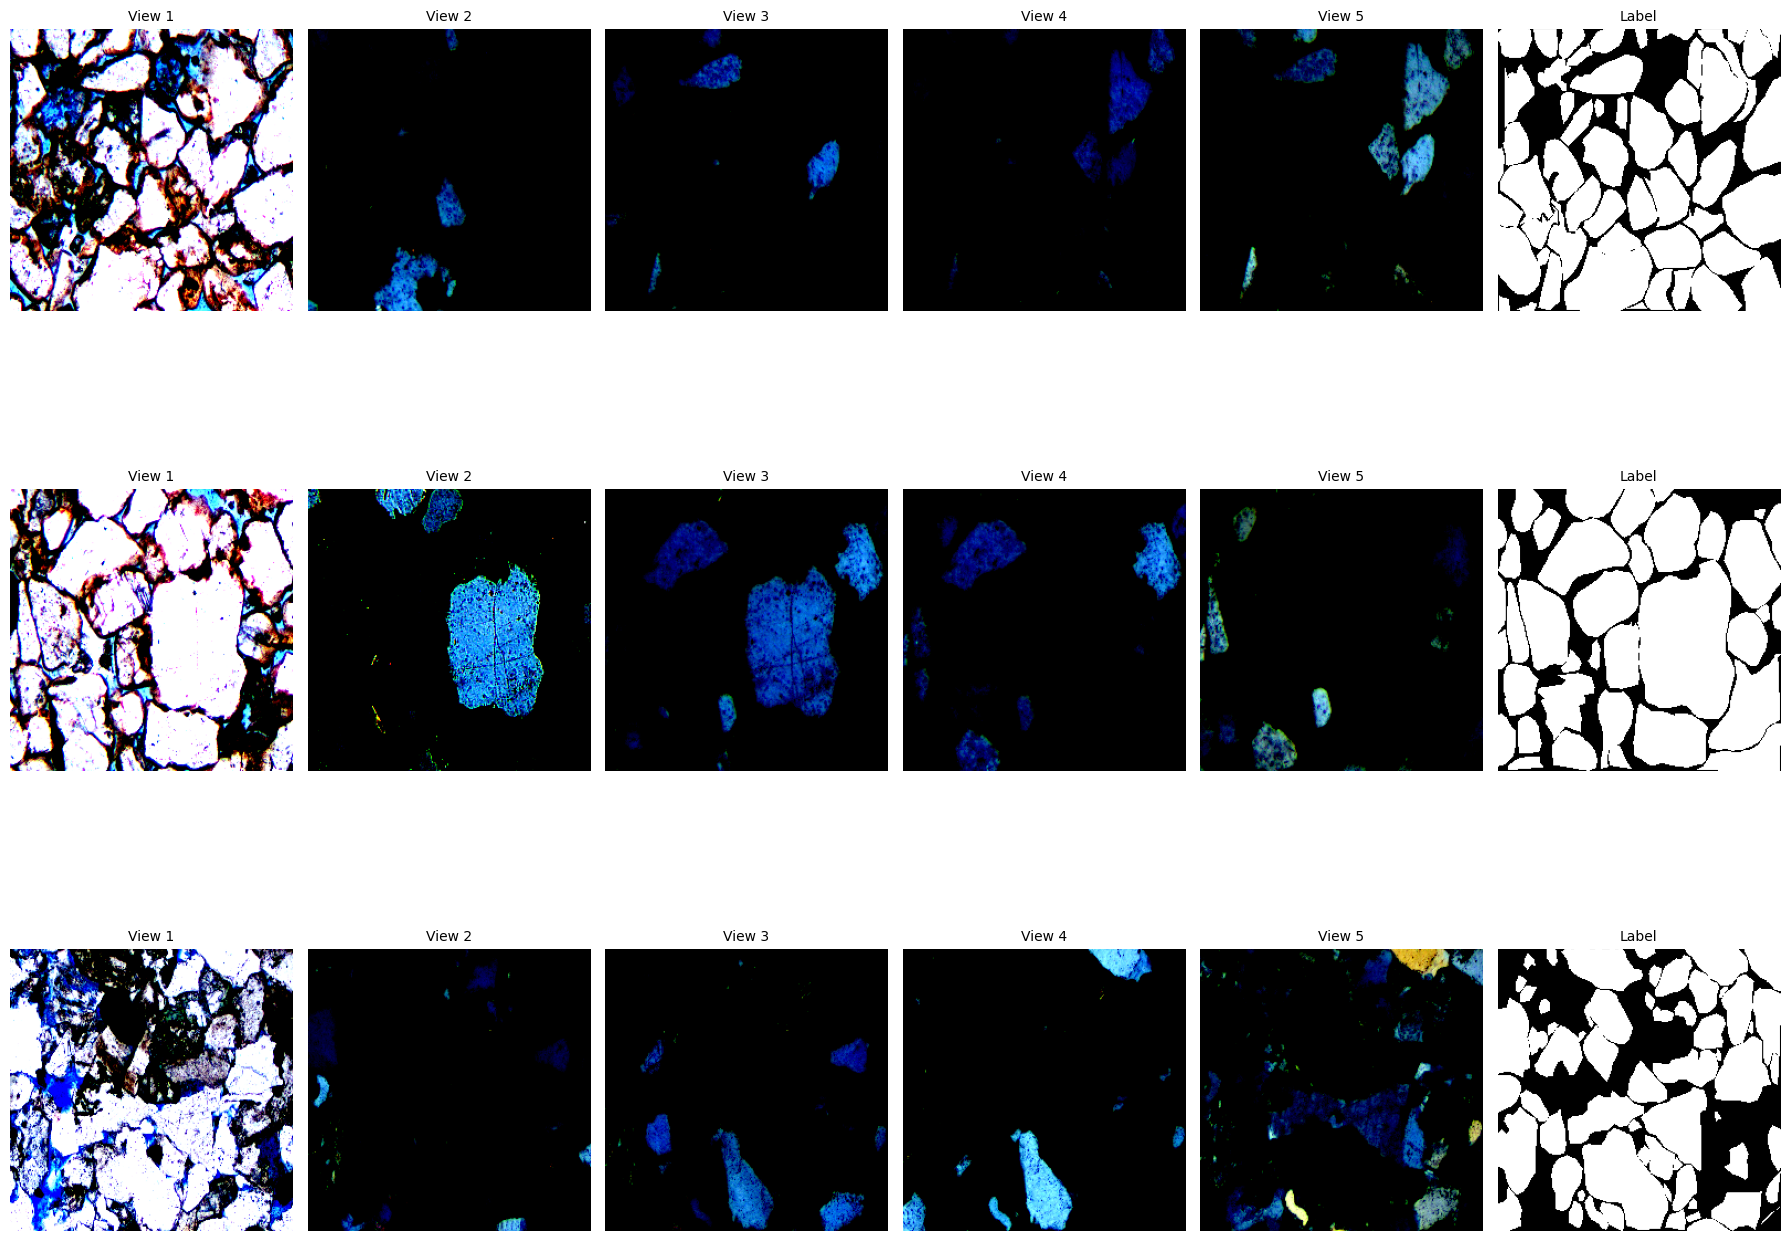

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 获取DataLoader中的多个样本（包含多视角图像和标签）
num_samples_to_show = 3  # 展示3个样本（可以根据需要调整）

# 创建一个大的子图用于展示多个样本
fig, axes = plt.subplots(num_samples_to_show, 6, figsize=(18, 5 * num_samples_to_show))  # 6列：5个视角图和1个标签图

for sample_idx in range(num_samples_to_show):
    # 获取当前样本，假设train_dataset返回的是（图像数据，标签数据）
    sample_images, labels = train_dataset[sample_idx]  # 根据你的数据集结构调整

    # 获取前五个视角，确保不会越界
    num_views = min(5, sample_images.shape[0])  # 假设每个样本有多个视角图像

    # 显示前五个视角图像
    for i in range(num_views):
        img = np.transpose(sample_images[i], (1, 2, 0))  # 转换维度 (C, H, W) -> (H, W, C)
        axes[sample_idx, i].imshow(img)  # 显示视角图像
        axes[sample_idx, i].axis('off')  # 关闭坐标轴
        axes[sample_idx, i].set_title(f"View {i+1}", fontsize=10)  # 添加视角标题并调整字体大小
        axes[sample_idx, i].spines['top'].set_linewidth(1)  # 增加边框
        axes[sample_idx, i].spines['right'].set_linewidth(1)
        axes[sample_idx, i].spines['left'].set_linewidth(1)
        axes[sample_idx, i].spines['bottom'].set_linewidth(1)

    # 显示标签图像，确保标签存在并且为一个图像
    if labels is not None and len(labels) > 0:  # 确保标签存在
        label_image = labels[0]  # 假设标签是一个单一的图像
        if len(label_image.shape) == 3:  # 如果标签图像有多个通道，转换为灰度图
            label_image = label_image[..., 0]  # 只取一个通道，假设标签是单通道
        axes[sample_idx, 5].imshow(label_image, cmap='gray')  # 显示标签图
        axes[sample_idx, 5].axis('off')  # 关闭坐标轴
        axes[sample_idx, 5].set_title("Label", fontsize=10)  # 标签标题
        axes[sample_idx, 5].spines['top'].set_linewidth(1)  # 增加边框
        axes[sample_idx, 5].spines['right'].set_linewidth(1)
        axes[sample_idx, 5].spines['left'].set_linewidth(1)
        axes[sample_idx, 5].spines['bottom'].set_linewidth(1)

# 自动调整子图间距
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # 增加子图间的水平和垂直间距
plt.tight_layout()  # 自动调整子图间距
plt.show()





In [ ]:
from pyswarm import pso  # 如果未安装，请运行：pip install pyswarm

# 定义搜索空间 [min, max]，例如 lr、weight_decay、dropout_rate
def fitness_function(params):
    lr, weight_decay, dropout = params

    # 构造模型，替换 dropout
    model = PMFSNetWithUNet(dropout_rate=dropout).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 一个 epoch 验证指标作为评价，或多 epoch 平均验证 F1-score
    best_val_f1 = 0.0
    for epoch in range(2):  # 这里只跑 2 个 epoch 以减少PSO时间开销
        model.train()
        for images, ground_truth in train_loader:
            images, ground_truth = images.to(device), ground_truth.to(device)
            optimizer.zero_grad()
            prediction = model(images)
            loss = criterion(prediction, ground_truth.float())
            loss.backward()
            optimizer.step()

        # 简化的验证流程（只取一个batch）
        model.eval()
        with torch.no_grad():
            for val_images, val_labels in test_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_preds = torch.sigmoid(model(val_images)) > 0.5
                val_preds = val_preds.float()
                val_f1 = calculate_precision_recall_f1(
                    val_preds.cpu().numpy().flatten(), val_labels.cpu().numpy().flatten()
                )[-1]
                best_val_f1 = max(best_val_f1, val_f1)
                break  # 只计算一个batch
    return -best_val_f1  # PSO默认是最小化目标函数


In [ ]:
# 粒子群边界：[lr, weight_decay, dropout_rate]
lb = [1e-5, 1e-6, 0.0]
ub = [1e-2, 1e-3, 0.5]

best_params, best_score = pso(fitness_function, lb, ub, swarmsize=10, maxiter=5)
print("Best Parameters found by PSO:")
print(f"Learning Rate: {best_params[0]:.6f}, Weight Decay: {best_params[1]:.6f}, Dropout: {best_params[2]:.2f}")


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn

# 定义模型、损失函数和优化器
model = PMFSNetWithUNet().to(device)  # 确保模型类名称正确
# model =().to(device) 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
# 定义学习率调度器（调整依据：F1-score）
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=5, min_lr=1e-6)

best_val_f1 = 0.0
best_model_state_dict = None
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []
train_iou_scores = []
val_iou_scores = []

for epoch in range(num_epochs):
    # **训练阶段**
    model.train()
    train_loss = 0
    all_iou_main = []
    all_train_preds = []
    all_train_labels = []

    for images, ground_truth in train_loader:
        images, ground_truth = images.to(device), ground_truth.to(device)


        optimizer.zero_grad()

        prediction1 = model(images)
        main_region_label = ground_truth.float()
        loss = criterion(prediction1, main_region_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.8)
        optimizer.step()

        # **记录 loss**
        train_loss += loss.item()  # 这里是关键

        # 计算 IoU
        prediction_main = (torch.sigmoid(prediction1) > 0.5).float()
        all_train_preds.append(prediction_main.cpu().numpy().flatten())
        all_train_labels.append(main_region_label.cpu().numpy().flatten())

        batch_iou_main = calculate_iou(prediction_main, main_region_label)
        all_iou_main.append(batch_iou_main)

    # 计算训练集的指标
    average_train_loss = train_loss / len(train_loader)  # 计算平均 loss
    average_iou_main = sum(all_iou_main) / len(all_iou_main) if all_iou_main else 0
    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    precision, recall, train_f1 = calculate_precision_recall_f1(all_train_preds, all_train_labels)

    # **存储数据**
    train_losses.append(average_train_loss)
    train_f1_scores.append(train_f1)
    train_iou_scores.append(average_iou_main)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {average_train_loss:.4f}, '
          f'IoU: {average_iou_main:.4f}, F1: {train_f1:.4f}')

# **验证阶段**
    model.eval()
    val_loss = 0
    all_val_iou_main = []
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for val_images, val_ground_truth in test_loader:
            val_images, val_ground_truth = val_images.to(device), val_ground_truth.to(device)
            val_prediction1 = model(val_images)
            val_main_region_label = val_ground_truth.float()
            val_loss += criterion(val_prediction1, val_main_region_label).item()

            val_prediction_probs = torch.sigmoid(val_prediction1)
            val_prediction_main = (val_prediction_probs > 0.5).float()

            all_val_preds.append(val_prediction_main.cpu().numpy().flatten())
            all_val_labels.append(val_main_region_label.cpu().numpy().flatten())

            val_iou_main = calculate_iou(val_prediction_main, val_main_region_label)
            all_val_iou_main.append(val_iou_main)

    # 计算验证集的指标
    average_val_loss = val_loss / len(test_loader)
    average_val_iou_main = sum(all_val_iou_main) / len(all_val_iou_main) if all_val_iou_main else 0
    all_val_preds = np.concatenate(all_val_preds)
    all_val_labels = np.concatenate(all_val_labels)
    val_precision, val_recall, val_f1 = calculate_precision_recall_f1(all_val_preds, all_val_labels)

    # **存储数据**
    val_losses.append(average_val_loss)
    val_f1_scores.append(val_f1)
    val_iou_scores.append(average_val_iou_main)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Validation Loss: {average_val_loss:.4f}, '
          f'Validation IoU: {average_val_iou_main:.4f}, Validation F1: {val_f1:.4f}')

    # **调整学习率**
    scheduler.step(val_f1)

    # **打印当前学习率**
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current Learning Rate: {current_lr:.6f}')

    # **保存最佳模型**
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state_dict = model.state_dict()
        print("New best model saved!")

    print(f"Best Validation F1: {best_val_f1:.4f}")
# 定义文件名
train_loss_file = "train_loss.txt"
val_loss_file = "val_loss.txt"
train_f1_file = "train_f1.txt"
val_f1_file = "val_f1.txt"
train_iou_file = "train_iou.txt"
val_iou_file = "val_iou.txt"

# 保存训练损失
with open(train_loss_file, "w") as f:
    for loss in train_losses:
        f.write(f"{loss:.6f}\n")

# 保存验证损失
with open(val_loss_file, "w") as f:
    for loss in val_losses:
        f.write(f"{loss:.6f}\n")

# 保存训练 F1-score
with open(train_f1_file, "w") as f:
    for f1 in train_f1_scores:
        f.write(f"{f1:.6f}\n")

# 保存验证 F1-score
with open(val_f1_file, "w") as f:
    for f1 in val_f1_scores:
        f.write(f"{f1:.6f}\n")

# 保存训练 IoU
with open(train_iou_file, "w") as f:
    for iou in train_iou_scores:
        f.write(f"{iou:.6f}\n")

# 保存验证 IoU
with open(val_iou_file, "w") as f:
    for iou in val_iou_scores:
        f.write(f"{iou:.6f}\n")

print(f"Training and validation metrics saved separately.")

# 保存最佳模型
best_model_path = "mymodel.pth"
torch.save(best_model_state_dict, best_model_path)
print(f"Best model saved to {best_model_path}")

KeyboardInterrupt: 

C:\Users\Admin\AppData\Local\Temp\ipykernel_26008\453451350.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mymodel.pth", map_location=

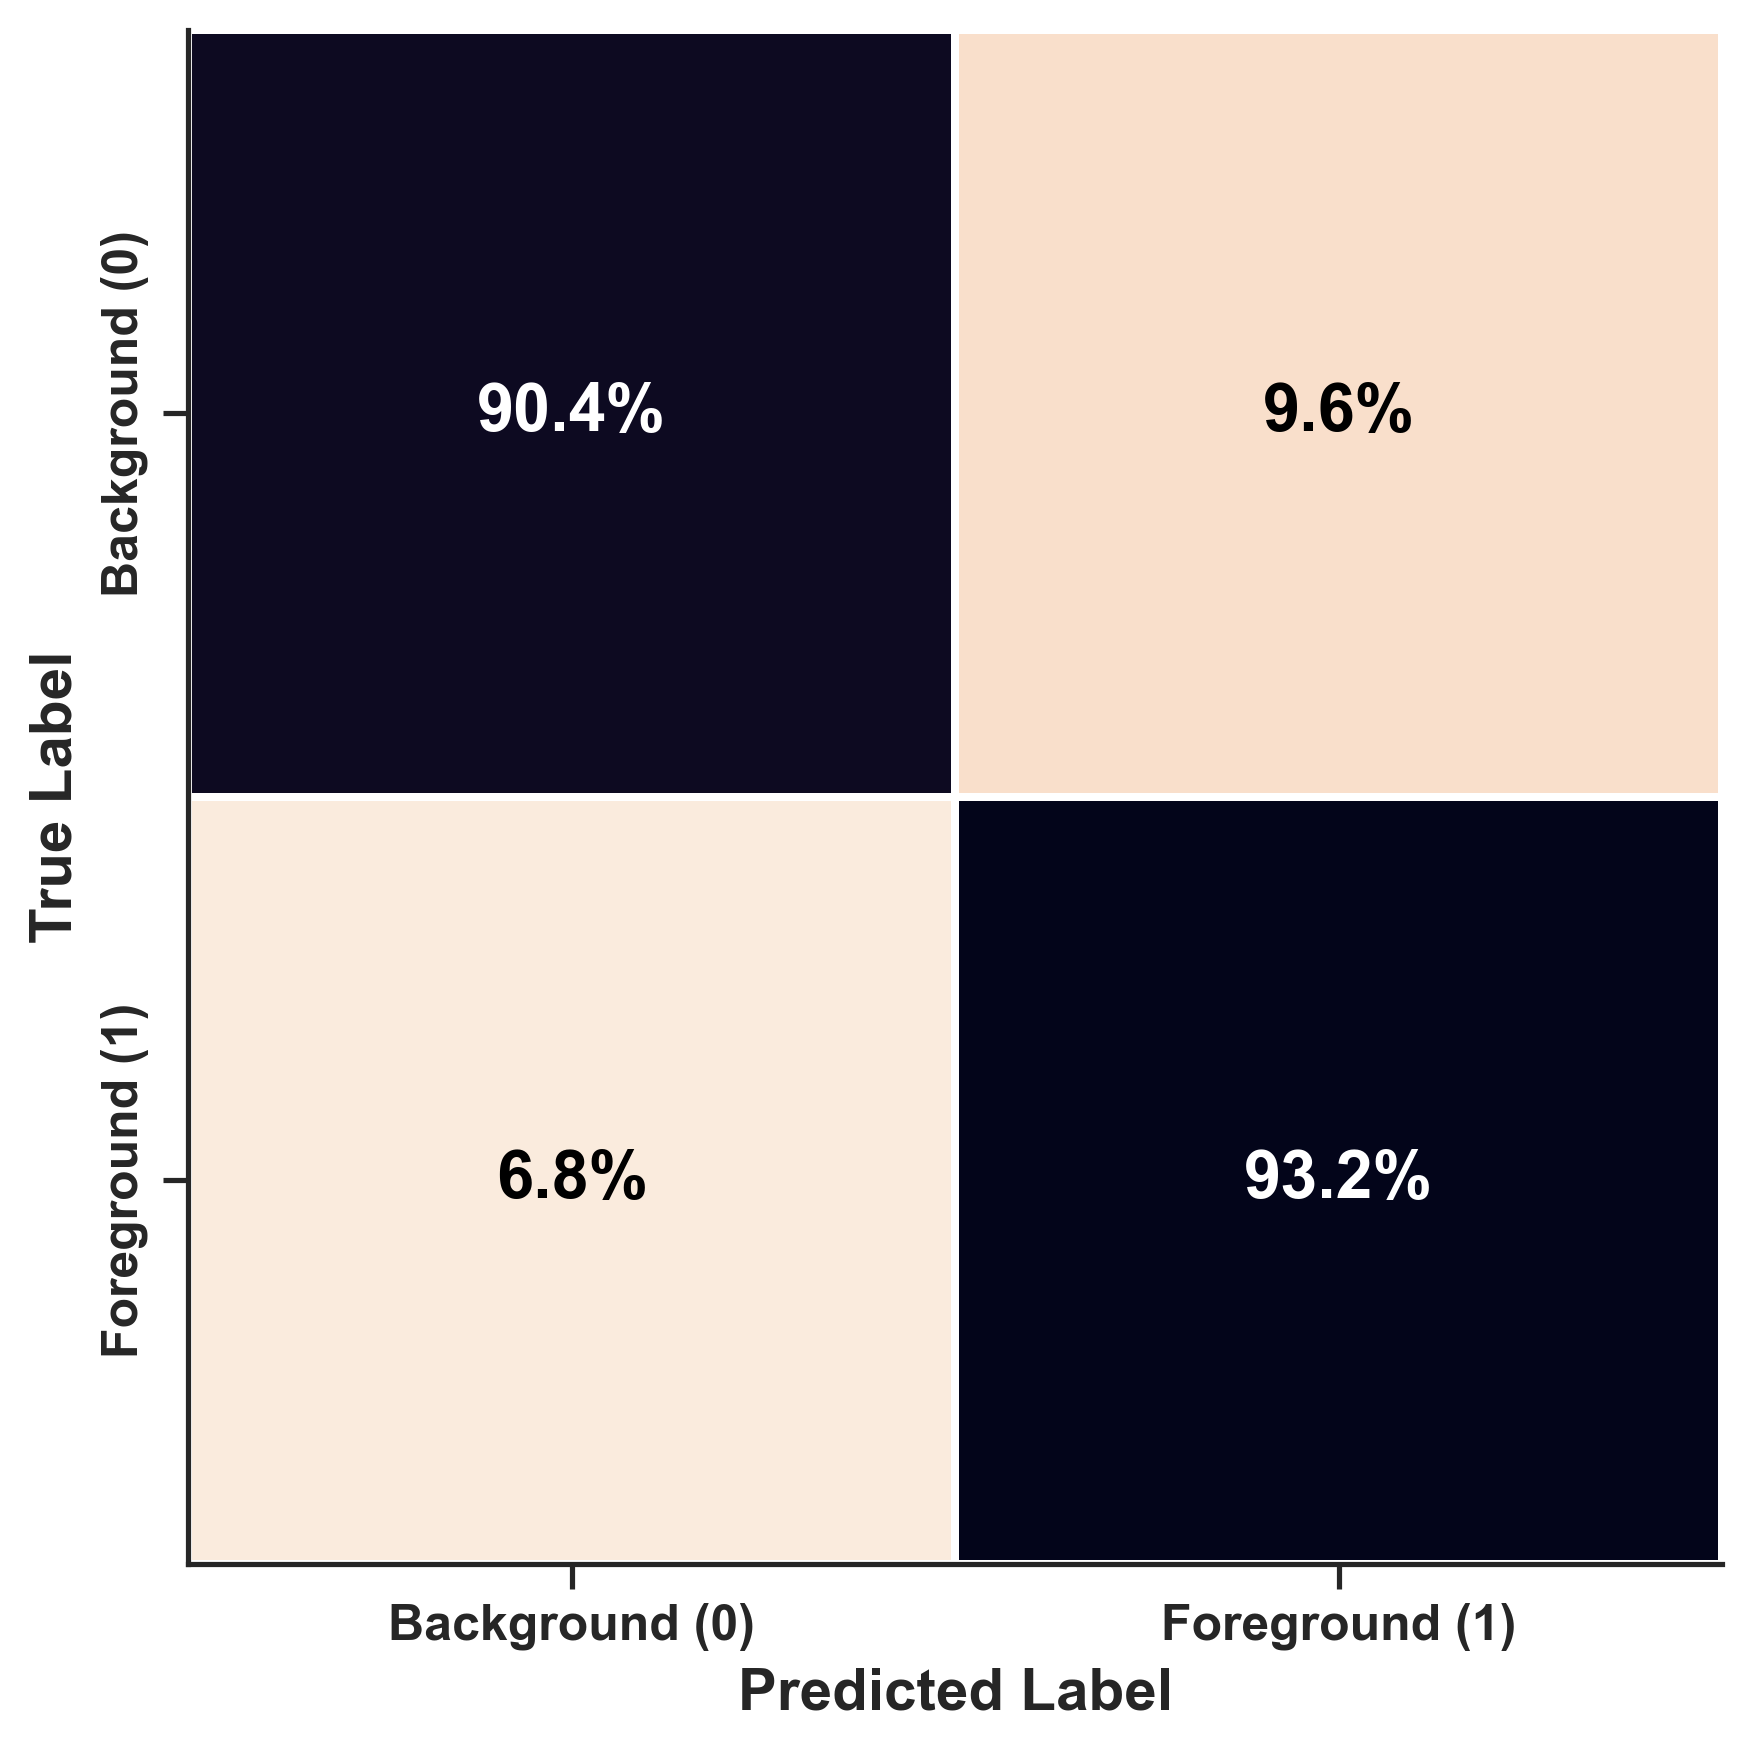

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
model = model.to(device)

model.load_state_dict(torch.load("mymodel.pth", map_location=device))
model.eval()


# ==== 3. 模型预测并收集预测与标签 ====
all_preds = []
all_labels = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)  # shape: (1, C, H, W)
        label = label.to(device)  # shape: (1, 1, H, W)
        
        output = model(data)  # shape: (1, 1, H, W)
        prob = torch.sigmoid(output)
        pred = (prob > 0.5).float()

        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

# ==== 4. 转为一维并构造混淆矩阵 ====
all_preds = np.concatenate(all_preds).flatten()
all_labels = np.concatenate(all_labels).flatten()

TP = np.sum((all_labels == 1) & (all_preds == 1))
TN = np.sum((all_labels == 0) & (all_preds == 0))
FP = np.sum((all_labels == 0) & (all_preds == 1))
FN = np.sum((all_labels == 1) & (all_preds == 0))

cm = np.array([[TN, FP],
               [FN, TP]])
cm_percent = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True) * 100
annot = np.array([[f"{val:.1f}%" for val in row] for row in cm_percent])

# ==== 5. 绘图 ====
sns.set(style="ticks")
plt.figure(figsize=(6, 6), dpi=300)
ax = sns.heatmap(cm_percent,
                 annot=False,
                 cmap='rocket_r',
                 xticklabels=["Background (0)", "Foreground (1)"],
                 yticklabels=["Background (0)", "Foreground (1)"],
                 cbar=False,
                 linewidths=1.5,
                 linecolor='white',
                 square=True)

for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        val = cm_percent[i, j]
        color = ax.collections[0].get_cmap()(val / 100)
        luminance = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
        text_color = 'black' if luminance > 0.5 else 'white'
        ax.text(j + 0.5, i + 0.5, f"{val:.1f}%", 
                ha='center', va='center',
                fontsize=16, weight='bold', color=text_color)

ax.set_xlabel("Predicted Label", fontsize=14, fontweight='bold')
ax.set_ylabel("True Label", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='semibold')
plt.yticks(fontsize=12, fontweight='semibold')

sns.despine()
plt.tight_layout()
plt.show()



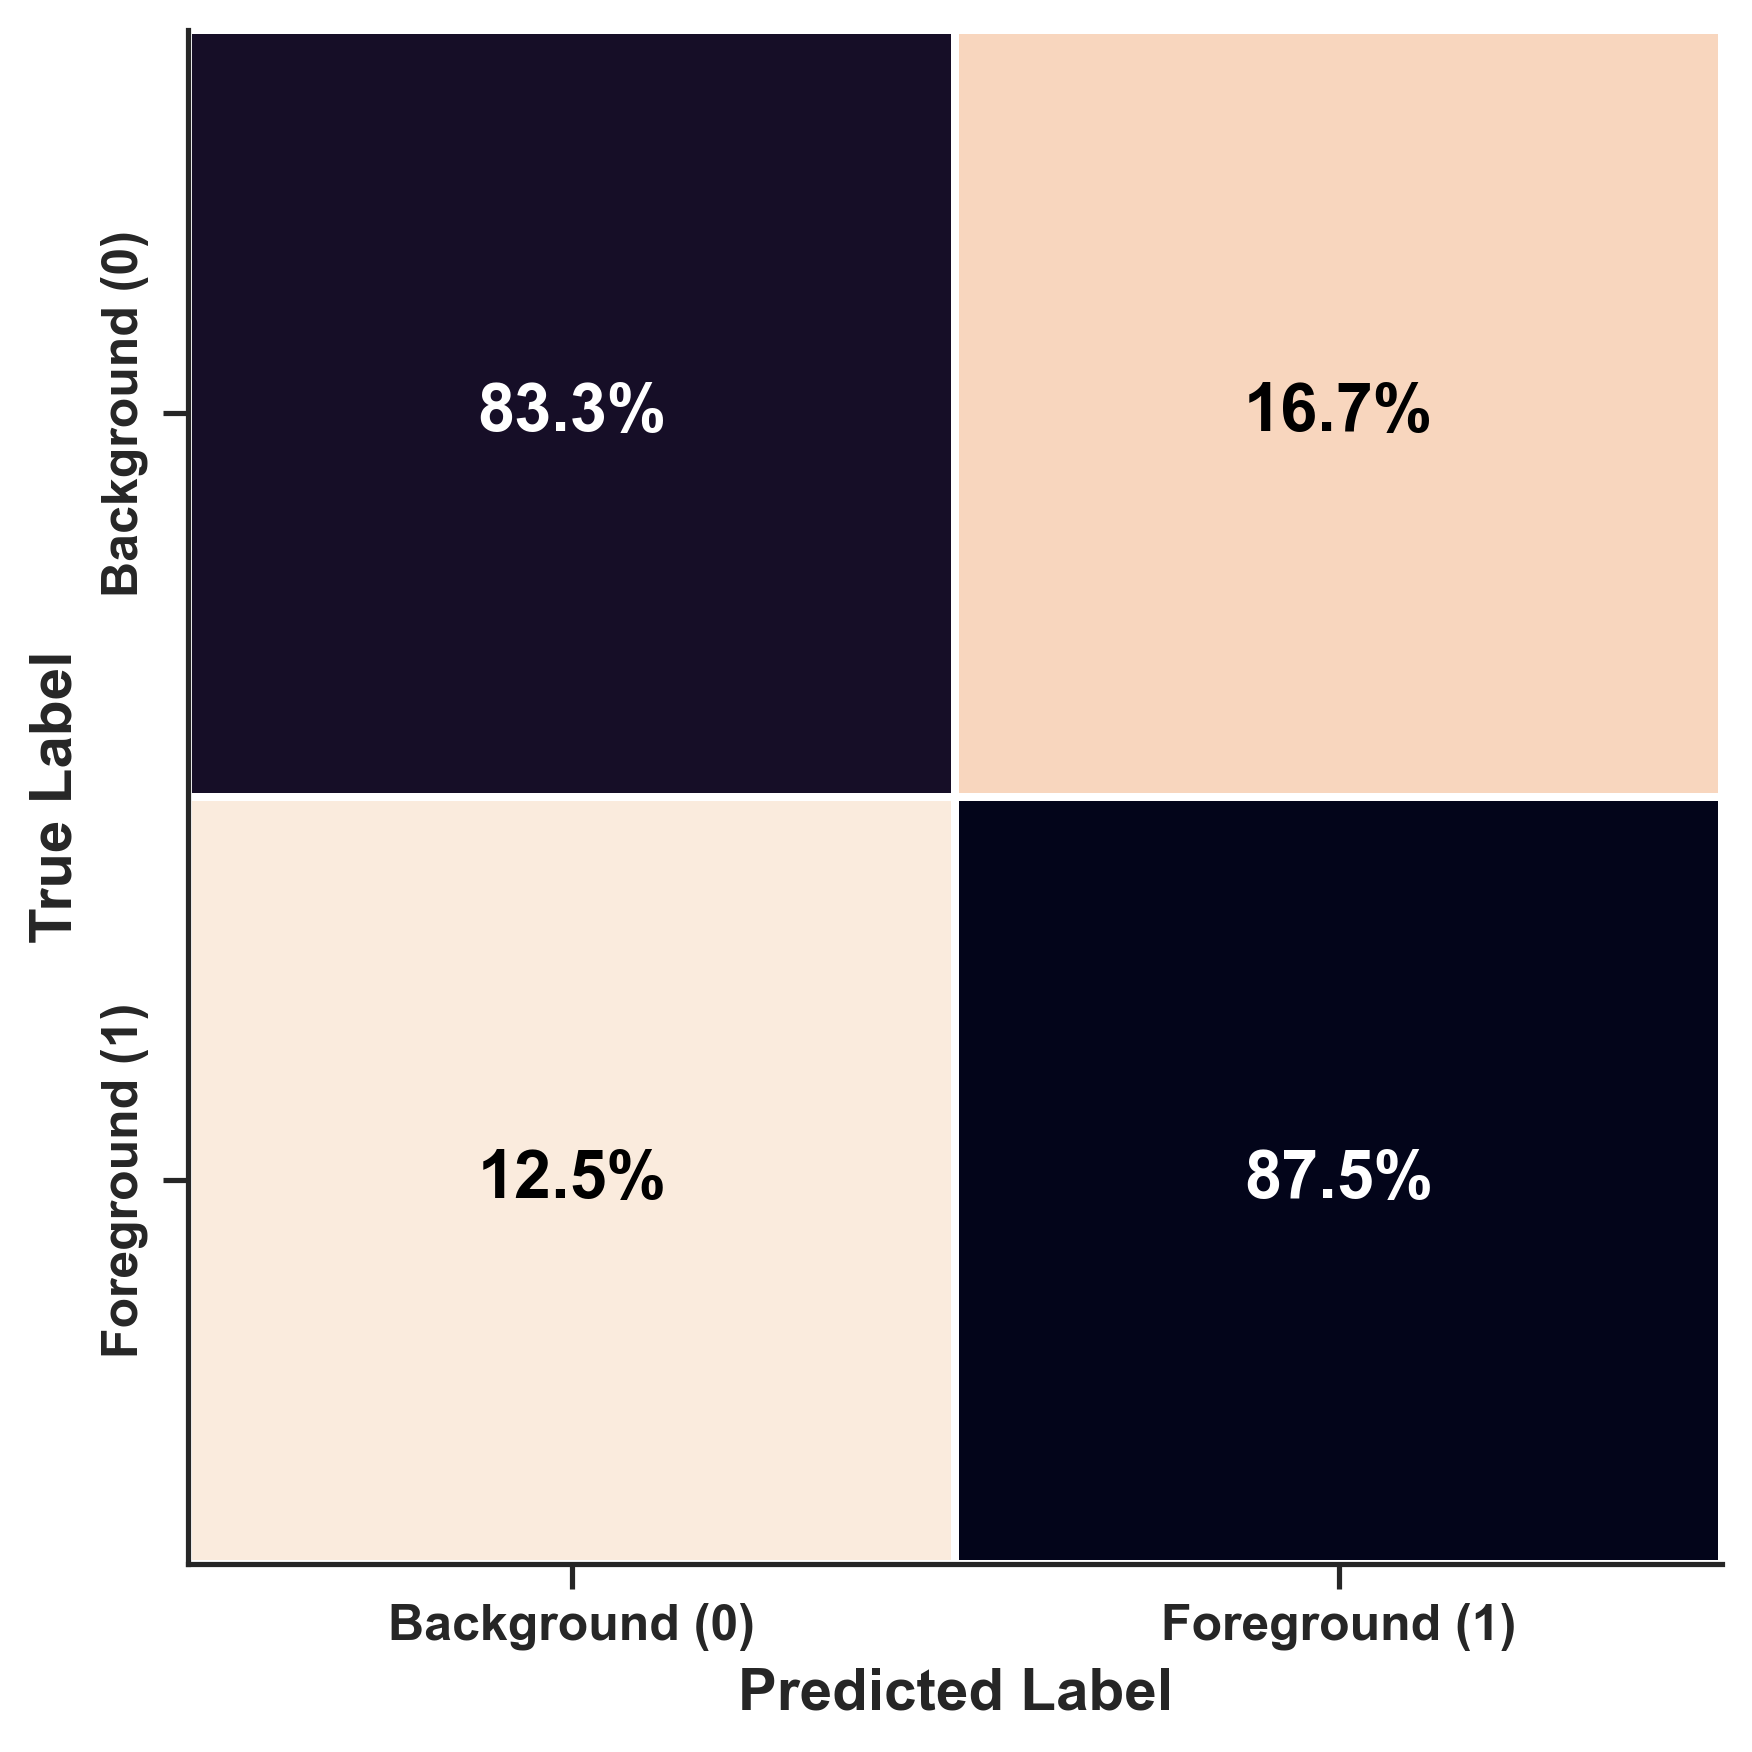

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 示例混淆矩阵
cm = np.array([[50, 10], [5, 35]])

# 计算百分比矩阵
cm_percent = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True) * 100

# 手动格式化百分比文本
annot = np.array([[f"{val:.1f}%" for val in row] for row in cm_percent])

# 绘图
sns.set(style="ticks")
plt.figure(figsize=(6, 6), dpi=300)

ax = sns.heatmap(cm_percent,
                 annot=False,  # 关闭内部格式化
                 cmap='rocket_r',  # 高对比度渐变色
                 xticklabels=["Background (0)", "Foreground (1)"],
                 yticklabels=["Background (0)", "Foreground (1)"],
                 cbar=False,
                 linewidths=1.5,
                 linecolor='white',
                 square=True)

# 动态设置字体颜色
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        val = cm_percent[i, j]
        color = ax.collections[0].get_cmap()(val / 100)  # 获取当前背景色
        luminance = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]  # 计算亮度
        text_color = 'black' if luminance > 0.5 else 'white'  # 亮背景用黑字，暗背景用白字
        ax.text(j + 0.5, i + 0.5, f"{val:.1f}%", 
                ha='center', va='center',
                fontsize=16, weight='bold', color=text_color)

# 美化标签和坐标
ax.set_xlabel("Predicted Label", fontsize=14, fontweight='bold')
ax.set_ylabel("True Label", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='semibold')
plt.yticks(fontsize=12, fontweight='semibold')

sns.despine()
plt.tight_layout()
plt.show()



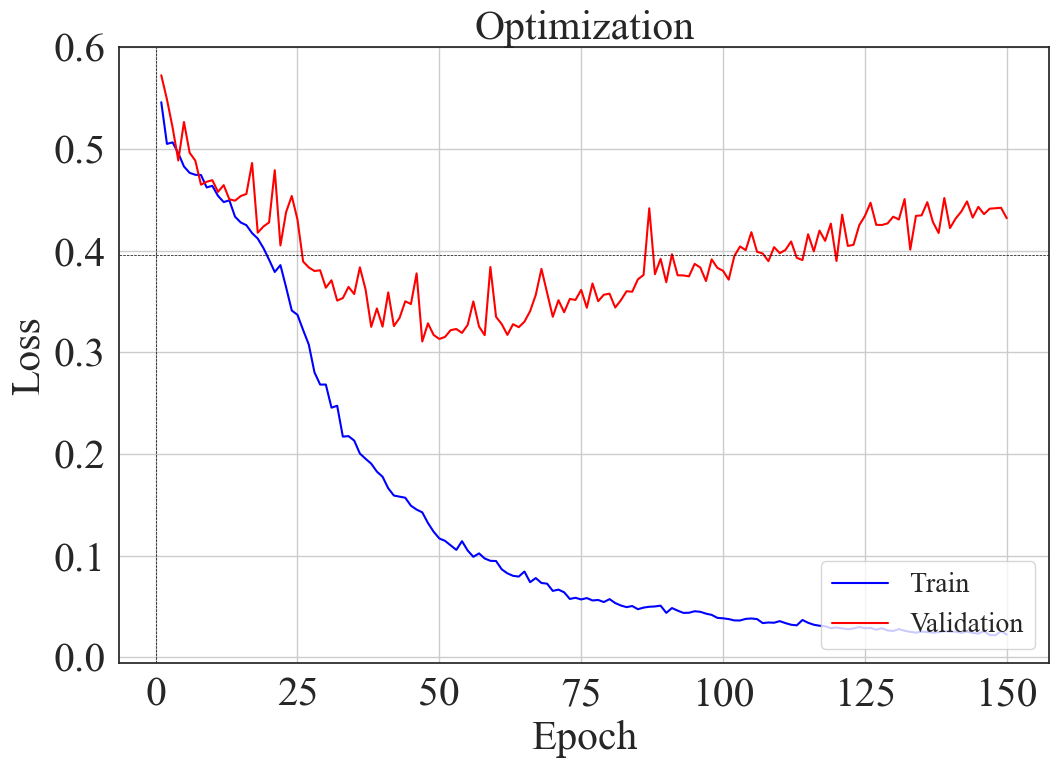

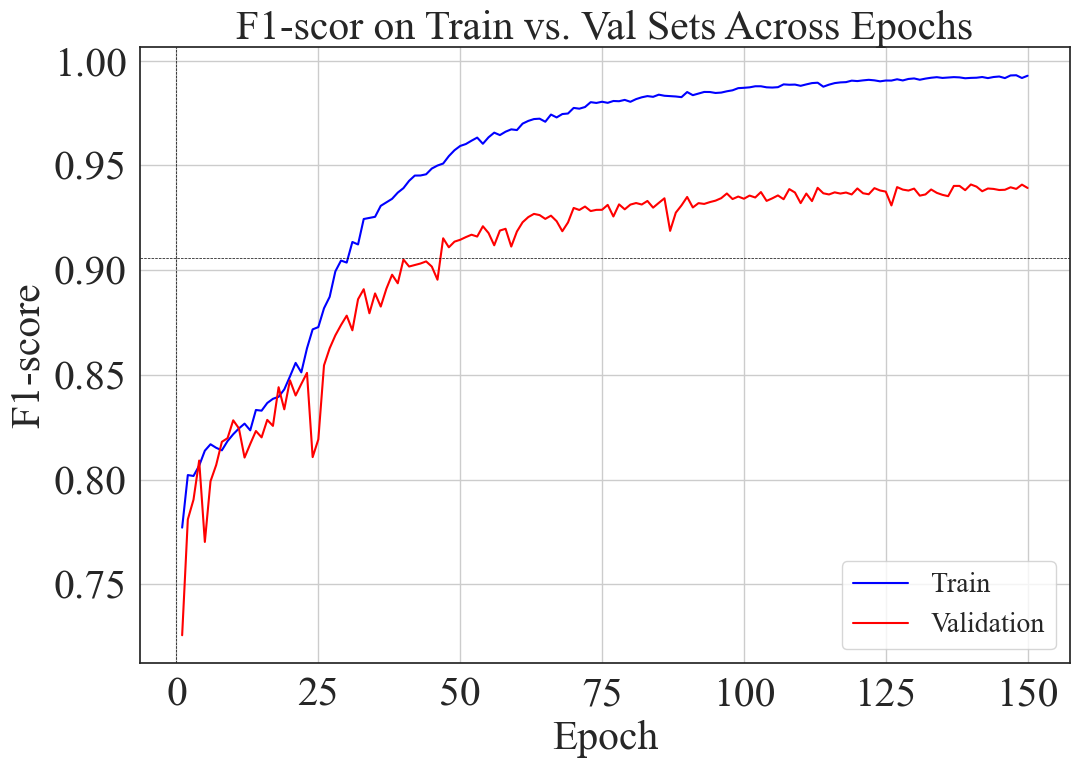

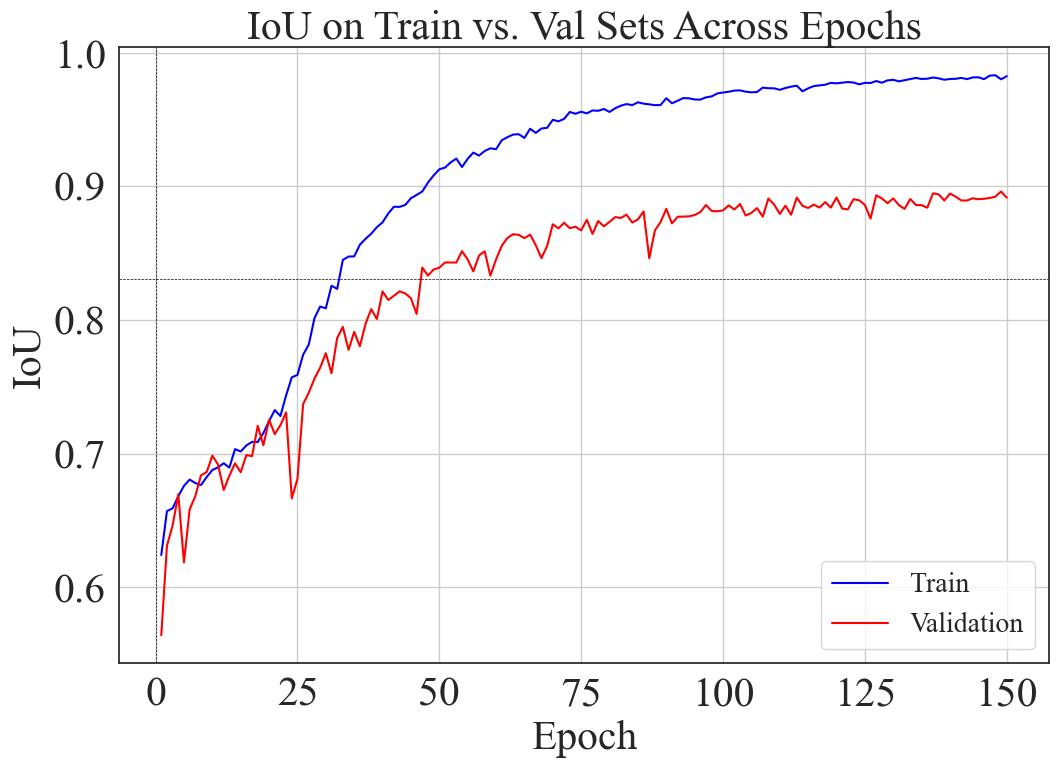

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 读取 txt 文件数据
def read_txt(filename):
    with open(filename, "r") as f:
        return [float(line.strip()) for line in f.readlines()]

# 读取不同指标的数据
train_losses = read_txt("train_loss.txt")
val_losses = read_txt("val_loss.txt")
train_f1_scores = read_txt("train_f1.txt")
val_f1_scores = read_txt("val_f1.txt")
train_iou_scores = read_txt("train_iou.txt")
val_iou_scores = read_txt("val_iou.txt")

# 生成 epoch 序列
epochs = list(range(1, len(train_losses) + 1))

# 设置 Seaborn 风格
sns.set(style="white")
sns.set_palette('Set2')

# 设置全局字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 30  # x 轴刻度大小
plt.rcParams['ytick.labelsize'] = 30  # y 轴刻度大小

# 统一绘图函数
def plot_metric(train_values, val_values, title, ylabel, filename):
    plt.figure(figsize=(12, 8))

    # 创建 DataFrame
    data = pd.DataFrame({
        'Epoch': epochs,
        'Train': train_values,
        'Validation': val_values
    })

    # 绘制曲线
    sns.lineplot(data=data, x='Epoch', y='Train', label='Train', color='blue')
    sns.lineplot(data=data, x='Epoch', y='Validation', label='Validation', color='red')

    # 设置标题 & 轴标签
    plt.title(title, fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.ylabel(ylabel, fontsize=30)

    # 辅助线
    plt.axhline(np.mean(val_values), color='black', linewidth=0.5, ls='--')  # 水平参考线
    plt.axvline(0, color='black', linewidth=0.5, ls='--')  # 纵向参考线

    # 图例 & 网格
    plt.legend(loc='lower right', prop={'size': 20})
    plt.grid()

    # 保存图像
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # 显示图像
    plt.show()

# 画 Loss 曲线
plot_metric(train_losses, val_losses, 'Optimization', 'Loss', 'loss_curve.png')

# 画 F1-score 曲线
plot_metric(train_f1_scores, val_f1_scores, 'F1-scor on Train vs. Val Sets Across Epochs', 'F1-score', 'f1_curve.png')

# 画 IoU 曲线
plot_metric(train_iou_scores, val_iou_scores, 'IoU on Train vs. Val Sets Across Epochs', 'IoU', 'iou_curve.png')



C:\Users\Admin\AppData\Local\Temp\ipykernel_23328\1620480768.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet mul.pth", map_locati

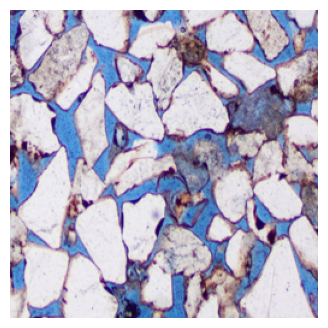

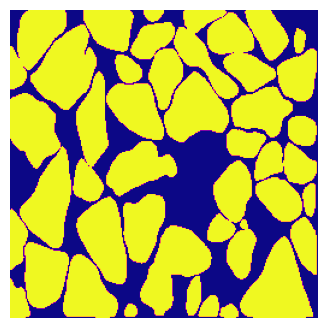

C:\Users\Admin\AppData\Local\Temp\ipykernel_23328\1620480768.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')


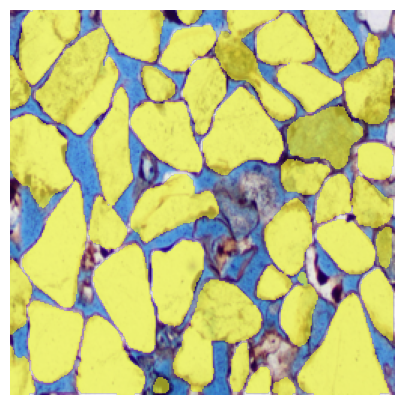

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型
model = UNetWithMultiScale().to(device)
model.load_state_dict(torch.load("unet mul.pth", map_location=device))
model.eval()

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# 子文件夹
target_folder = "130"
folder_path = os.path.join("D:/picture", target_folder)

# 获取图像路径
all_files = sorted(os.listdir(folder_path))
image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if len(image_files) < 5:
    raise ValueError("该文件夹中图像不足5张！")

image_paths = [os.path.join(folder_path, f) for f in image_files[:5]]

# 加载图像
image_list = []
original_images = []
for path in image_paths:
    img = Image.open(path).convert("RGB").resize((256, 256))
    original_images.append(np.array(img))  # 保存原图用于展示
    img = transform(img)
    image_list.append(img)

# 拼接为模型输入
image_tensor = torch.stack(image_list, dim=0).unsqueeze(0).to(device)  # [1, 5, 3, 256, 256]

# 模型推理
with torch.no_grad():
    prediction = model(image_tensor)
    prediction_probs = torch.sigmoid(prediction)
    prediction_binary = (prediction_probs > 0.5).float()

# 提取第一个视角的掩膜
if prediction_binary.dim() == 5:
    mask_first_view = prediction_binary[0, 0, 0].cpu().numpy()
elif prediction_binary.dim() == 4:
    mask_first_view = prediction_binary[0, 0].cpu().numpy()
else:
    raise RuntimeError("掩膜输出维度不符合预期")

# 展示第1张原图
plt.figure(figsize=(4, 4))
plt.imshow(original_images[0])
plt.axis("off")
plt.show()

# 展示第1张掩膜图（plasma色图，更美观）
plt.figure(figsize=(4, 4))
plt.imshow(mask_first_view, cmap="plasma")
plt.axis("off")
plt.show()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# 原图：第一个视角
original_img = original_images[0]  # shape: [H, W, 3], dtype: uint8
mask = mask_first_view  # shape: [H, W], dtype: float32

# 创建伪彩色图（使用 plasma colormap）
cmap = cm.get_cmap('plasma')
colored_mask = cmap(mask)  # 返回 RGBA，值域 [0,1]

# 设置 alpha 透明度（0.6），保留掩膜的彩色信息
alpha = 0.6
colored_mask[..., 3] = mask * alpha  # 只对掩膜区域加透明度，背景透明

# 显示叠加图
plt.figure(figsize=(5, 5))
plt.imshow(original_img)
plt.imshow(colored_mask)
plt.axis("off")
plt.show()


In [ ]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 保存黑白图像函数（加边框，美观）
def save_single_image(image, path, cmap='gray', border=True):
    plt.figure(figsize=(4, 4), facecolor='white')

    plt.imshow(image, cmap=cmap, vmin=0, vmax=1)  # 黑白对比明确
    plt.axis('off')

    if border:
        ax = plt.gca()
        for side in ['top', 'right', 'bottom', 'left']:
            ax.spines[side].set_visible(True)
            ax.spines[side].set_color('black')
            ax.spines[side].set_linewidth(2)

    plt.tight_layout(pad=0)
    plt.savefig(path, bbox_inches='tight', pad_inches=0.1, dpi=125)
    plt.close()

# 创建保存路径
save_root = r"D:\output\mutil unet"
#save_root = r"D:\output\attention"
os.makedirs(save_root, exist_ok=True)

# 模型评估
model.eval()
val_images_to_visualize = []
val_ground_truth_to_visualize = []
val_predictions_to_visualize = []

with torch.no_grad():
    for val_images, val_ground_truth in test_loader:
        val_images, val_ground_truth = val_images.to(device), val_ground_truth.to(device)

        val_prediction1 = model(val_images)
        val_prediction_probs = torch.sigmoid(val_prediction1)
        val_prediction_main = (val_prediction_probs > 0.5).float()

        for i in range(val_images.size(0)):
            val_images_to_visualize.append(val_images[i, 0].cpu())  # 使用通道0
            val_ground_truth_to_visualize.append(val_ground_truth[i].cpu())
            val_predictions_to_visualize.append(val_prediction_main[i].cpu())

# 可视化与保存
for idx in range(len(val_images_to_visualize)):
    # 原图：灰度归一化
    image = val_images_to_visualize[idx].permute(1, 2, 0).numpy().mean(axis=-1)
    image = (image - image.min()) / (image.max() - image.min())

    # 标签与预测：二值化（黑白）
    label = val_ground_truth_to_visualize[idx].squeeze().numpy()
    label = (label > 0.5).astype(np.float32)  # 强制二值

    prediction = val_predictions_to_visualize[idx].squeeze().numpy()
    prediction = (prediction > 0.5).astype(np.float32)

    # 保存路径
    image_path = os.path.join(save_root, f"image_{idx + 1}.png")
    label_path = os.path.join(save_root, f"label_{idx + 1}.png")
    prediction_path = os.path.join(save_root, f"prediction_{idx + 1}.png")

    # 保存图像（全部黑白）
    save_single_image(image, image_path, cmap='gray')
    save_single_image(label, label_path, cmap='gray')
    save_single_image(prediction, prediction_path, cmap='gray')






import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 图像和像素参数
image_size = 256  # 256x256 图像
pixel_to_mm = 0.2
pixel_area_to_mm2 = pixel_to_mm ** 2
image_area_mm2 = (image_size * image_size) * pixel_area_to_mm2  # 2621.44 mm²

# 几何特征提取
def analyze_geometrical_properties(binary_mask):
    labeled_img = label(binary_mask)
    props = regionprops(labeled_img)

    data = []
    for prop in props:
        area_px = prop.area
        perimeter_px = prop.perimeter
        circularity = (4 * np.pi * area_px) / (perimeter_px ** 2) if perimeter_px > 0 else 0
        minr, minc, maxr, maxc = prop.bbox
        width = maxc - minc
        height = maxr - minr
        aspect_ratio = width / height if height > 0 else 0

        data.append({
            'Area (mm²)': area_px * pixel_area_to_mm2,
            'Perimeter (mm)': perimeter_px * pixel_to_mm,
            'Circularity': circularity,
            'Aspect Ratio': aspect_ratio
        })

    return pd.DataFrame(data)

# 加载模型
model = PMFSNetWithUNet().to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

statistics_list = []

for batch_idx, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    batch_size = images.shape[0]

    with torch.no_grad():
        predictions = model(images)
        probs = torch.sigmoid(predictions)
        preds = (probs > 0.5).float().cpu().numpy()

    for i in range(batch_size):
        binary_mask = preds[i, 0].astype(np.uint8)

        df_detail = analyze_geometrical_properties(binary_mask)

        image_id = f"test_image_{batch_idx * batch_size + i:03d}"

        # ✅ 显示面积直方图
        if not df_detail.empty:
            plt.figure()
            plt.hist(df_detail['Area (mm²)'], bins=20, color='skyblue', edgecolor='black')
            plt.title(f"Area Histogram - {image_id}")
            plt.xlabel("Area (mm²)")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()

        # ✅ 计算孔隙率
        total_grain_area = df_detail['Area (mm²)'].sum() if not df_detail.empty else 0
        porosity = ((image_area_mm2 - total_grain_area) / image_area_mm2) * 100  # 正确公式

        summary = {
            'Image': image_id,
            'Num Grains': len(df_detail),
            'Mean Area (mm²)': df_detail['Area (mm²)'].mean() if not df_detail.empty else 0,
            'Std Area (mm²)': df_detail['Area (mm²)'].std() if not df_detail.empty else 0,
            'Max Area (mm²)': df_detail['Area (mm²)'].max() if not df_detail.empty else 0,
            'Min Area (mm²)': df_detail['Area (mm²)'].min() if not df_detail.empty else 0,
            'Mean Circularity': df_detail['Circularity'].mean() if not df_detail.empty else 0,
            'Mean Aspect Ratio': df_detail['Aspect Ratio'].mean() if not df_detail.empty else 0,
            'Porosity (%)': porosity
        }

        statistics_list.append(summary)

# 保存统计结果
df_statistics = pd.DataFrame(statistics_list)
df_statistics.to_csv("testset_geometry_statistics.csv", index=False)
print(f"✅ 几何特征分析完成，共处理图像: {len(df_statistics)} 张，已保存统计结果到 testset_geometry_statistics.csv")





In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage import color

# ======== 基本设置 ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 原始图像尺寸（单位：mm）
actual_width_mm = 2.015
actual_height_mm = 1.155
original_width_px = 2000
original_height_px = 1450
resized_size = 256

pixel_to_mm_x = actual_width_mm / original_width_px
pixel_to_mm_y = actual_height_mm / original_height_px
pixel_to_mm_avg = (pixel_to_mm_x + pixel_to_mm_y) / 2
pixel_to_mm = pixel_to_mm_avg
pixel_area_to_mm2 = pixel_to_mm ** 2
image_area_mm2 = (resized_size * resized_size) * pixel_area_to_mm2

def extract_blue_pores(image):
    """
    使用 HSV 颜色空间进行蓝色区域提取（纯蓝提取更准确）
    """
    # 将 RGB 转为 BGR（因为 OpenCV 默认是 BGR）
    image_bgr = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

    # 转换到 HSV 空间
    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # 定义纯蓝范围（色相 H: 105~125 对应于 OpenCV 的范围 [0,179]）
    lower_blue = np.array([105, 100, 50])   # H, S, V
    upper_blue = np.array([125, 255, 255])

    # 生成掩码
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # 返回二值化结果（0 或 1）
    return (mask > 0).astype(np.uint8)



# ======== 几何特征计算函数（基于预测掩码） ========
def analyze_geometrical_properties(binary_mask):
    labeled_img = label(binary_mask)
    props = regionprops(labeled_img)

    data = []
    for prop in props:
        area_px = prop.area
        perimeter_px = prop.perimeter
        circularity = (4 * np.pi * area_px) / (perimeter_px ** 2) if perimeter_px > 0 else 0
        minr, minc, maxr, maxc = prop.bbox
        width = maxc - minc
        height = maxr - minr
        aspect_ratio = width / height if height > 0 else 0

        data.append({
            'Area (mm²)': area_px * pixel_area_to_mm2,
            'Perimeter (mm)': perimeter_px * pixel_to_mm,
            'Circularity': circularity,
            'Aspect Ratio': aspect_ratio
        })

    return pd.DataFrame(data)

# ======== 模型加载 ========
model = PMFSNetWithUNet().to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

statistics_list = []

for batch_idx, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    batch_size = images.shape[0]

    with torch.no_grad():
        predictions = model(images)
        probs = torch.sigmoid(predictions)
        preds = (probs > 0.5).float().cpu().numpy()

    for i in range(batch_size):
        image_id = f"test_image_{batch_idx * batch_size + i:03d}"

        # 预测结果（用于几何特征）
        binary_mask = preds[i, 0].astype(np.uint8)

        # 提取原图用于蓝色孔隙提取（取第一个视角）
        original_img = images[i, 0].cpu().numpy().transpose(1, 2, 0)  # (3,256,256)->(256,256,3)
        original_img = (original_img * 255).astype(np.uint8)

        # --- 计算几何特征 ---
        df_detail = analyze_geometrical_properties(binary_mask)

        # --- 计算孔隙度（基于蓝色） ---
        blue_mask = extract_blue_pores(original_img)
        blue_area = np.sum(blue_mask)
        porosity = (blue_area / (resized_size * resized_size)) * 100

        # --- 可视化 ---
        if not df_detail.empty:
            plt.figure()
            plt.hist(df_detail['Area (mm²)'], bins=20, color='skyblue', edgecolor='black')
            plt.title(f"Area Histogram - {image_id}")
            plt.xlabel("Area (mm²)")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()

        summary = {
            'Image': image_id,
            'Num Grains': len(df_detail),
            'Mean Area (mm²)': df_detail['Area (mm²)'].mean() if not df_detail.empty else 0,
            'Std Area (mm²)': df_detail['Area (mm²)'].std() if not df_detail.empty else 0,
            'Max Area (mm²)': df_detail['Area (mm²)'].max() if not df_detail.empty else 0,
            'Min Area (mm²)': df_detail['Area (mm²)'].min() if not df_detail.empty else 0,
            'Mean Circularity': df_detail['Circularity'].mean() if not df_detail.empty else 0,
            'Mean Aspect Ratio': df_detail['Aspect Ratio'].mean() if not df_detail.empty else 0,
            'Porosity (%)': porosity
        }

        statistics_list.append(summary)

# ======== 保存统计结果 ========
df_statistics = pd.DataFrame(statistics_list)
df_statistics.to_csv("testset_geometry_statistics.csv", index=False)
print(f"✅ 几何特征分析与孔隙度提取完成，共处理图像: {len(df_statistics)} 张，已保存至 testset_geometry_statistics.csv")


